In [1]:
# General scientific libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm, LinearSegmentedColormap, Normalize, SymLogNorm
from matplotlib import cm as colormap
import pandas as pd
import time
from string import ascii_lowercase
from scipy import special
from scipy import integrate
from scipy.special import roots_legendre, eval_legendre
from scipy.constants import mu_0, epsilon_0
# Machine Epssilon for float
import ipywidgets
import time
from PIL import Image
import os
eps = np.finfo(float).eps

In [2]:
# Specific Geophysics libraries
import empymod
from empymodDeepSea import empymodDeepSea
# SimPEG, discretize/
import discretize
from discretize import utils
from simpeg.electromagnetics import time_domain as tdem
from simpeg.electromagnetics import resistivity as dc
from simpeg.utils import mkvc, plot_1d_layer_model
from simpeg import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)
from geoana.em.tdem import diffusion_distance
from geoana.em.tdem import peak_time
from pymatsolver import Pardiso

In [3]:
from masa_utils import TEM_Signal_Process 
from masa_utils import empymod_IPinv
from masa_utils import PsuedoLog
from masa_utils import InducedPolarization

Simulatin and synthetic study on deep sea hydrothermal deposits explortaion using WISTEM (K. Nakayama and A. Saito, 2016) (K.Nakayama M. Motoori and A. Saito,2019).
On-Time: 200msec
ramp time: 200usec
Transmitter Loop: 3.5m Square Loop
Receiver Loop: Coincident-type
Number of Turn: 5
3.5m rectangular loop has equivalent area for 2.0m circular. 

In [4]:
# load simpeg emip data
emip_saved = np.load("14_Validation_simpegEMIP.npy")
time_emip = emip_saved[0,:]
dpred_emip = emip_saved[1,:] 
print(time_emip.shape)
print(dpred_emip.shape)
# load simpeg emip data
fields_saved = np.load("14_fields_emip.npy")[:,:,1:]
print(fields_saved.shape)
time_clc = np.load("14_time_clc.npy")
print(time_clc.shape)
ntime = time_clc.shape[0]

(460,)
(460,)
(31878, 1, 460)
(460,)


In [5]:
base_freq=1.25
on_time=200e-3
rmp_time=200e-6
rec_time=5e-3
smp_freq=50e3 #200e3  


In [6]:
# WISTEM_SP = TEM_Signal_Process (
#     base_freq=base_freq,
#     on_time=on_time,
#     rmp_time=rmp_time,
#     rec_time=rec_time,
#     smp_freq=smp_freq,
# )
WISTEM_SP_sim = TEM_Signal_Process (
    base_freq=base_freq,
    on_time=on_time,
    rmp_time=rmp_time,
    rec_time=rec_time,
    smp_freq=smp_freq*4.,
)


In [7]:
tx_side = 3.5
tx_radius = (tx_side)/(np.sqrt(np.pi))
tx_circumeference = 2*np.pi*tx_radius
tx_surface = np.pi*tx_radius**2
n_turns = 5
tx_depth = 0
print(f"Transmitter radius: {tx_radius}")

Transmitter radius: 1.9746635424171473


In [8]:
csx, csz = tx_radius/4.,tx_radius/4.
ncx, ncz  = 100, 100 
pf, npadx, npadz = 1.3 , 26, 26
hx = [(csx, ncx), (csx, npadx, pf)]
hz = [(csz, npadz, -pf), (csz, 2*ncz), (csz, npadz, pf)]
mesh = discretize.CylindricalMesh([hx,1,hz], '00C')    
print(f'number of mesh {mesh.nC}')

number of mesh 31752


In [9]:
con_sea = 3.0
res_sea = 1/con_sea
rho0_target = 0.15
con_target = 1/rho0_target
con_seabed = 1.0
res_base = 1.0/con_seabed
eta_target = 0.3
eta_sea , eta_base = 0.,0.
con8_target = con_target/(1-eta_target)
print(f'con8 {con8_target:.2e}')
print(f'con  {con_target:.2e}')
tau_target = 1.0e-3
tau_sea, tau_base, tau_ref = 1.0e-2, 1.0e-2, 1.0e-2
c_target = 0.8
c_sea, c_base, c_ref = 0.6,0.6,0.6
thick_target = 30.
tx_height = csx
print(tx_height)


con8 9.52e+00
con  6.67e+00
0.4936658856042868


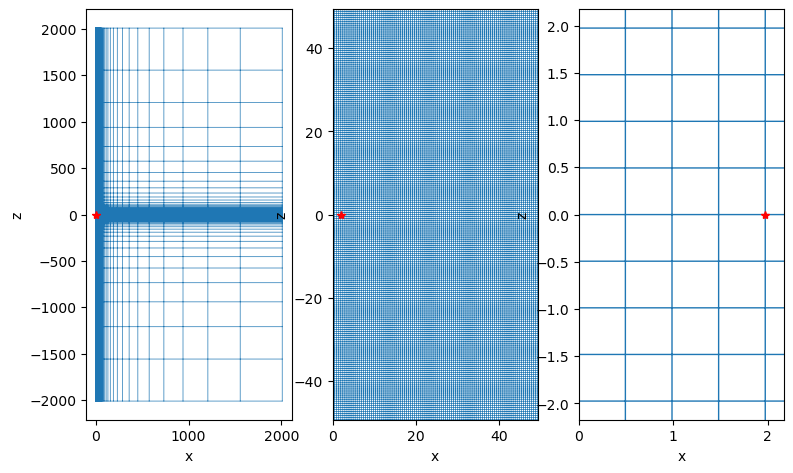

In [10]:
fig, ax = plt.subplots(1,3, figsize=(9,7))
ax[0] = mesh.plot_grid(ax=ax[0], show_it=False, linewidth=0.5)  
ax[1] =  mesh.plot_grid(ax=ax[1], show_it=False, linewidth=0.5)
#ax[1] =  mesh.plot_grid(show_it=True)
ax[1].set_xlim(0., ncx*csx)
ax[1].set_ylim(-ncz*csz , ncz*csz )
ax[2] =  mesh.plot_grid(ax=ax[2], show_it=False, linewidth=1.0)
ax[2].set_xlim(0.,tx_radius*1.1)
ax[2].set_ylim(-tx_radius*1.1,tx_radius*1.1)

for a in ax:
    a.set_aspect('equal')
    a.plot(tx_radius,0,'r*')
    a.grid(False)

# mapping

In [11]:
sigma_layer = {}
m = con_sea * np.ones(mesh.n_cells)
inds_layer = ((mesh.cell_centers[:, 2] <= -tx_height) &
              (mesh.cell_centers[:, 2] >= -tx_height- thick_target))
m[inds_layer] = con8_target #/(1-eta_target)
print(f"sigma_inf: {con8_target:3e}")
inds_seabed = mesh.cell_centers[:, 2] <= -tx_height-thick_target
m[inds_seabed] = con_seabed
sigma_layer = m.copy()

# eta = np.zeros(mesh.nC)
# tau = np.ones(mesh.nC) * 1.
# c = np.ones(mesh.nC) * 0.5

sigma_inf: 9.523810e+00


In [12]:
time_steps = [(2e-6,  150),  (5e-6,  150),  (2e-5,  150), (5e-5,  150)]
tstrt, tend = 1e-5, 1e-2

steps = np.array([])
for i in range(len(time_steps)):
    dt, n = time_steps[i]
    step_array = dt * np.ones(n)
    steps = np.concatenate((steps, step_array))
time_clc = np.cumsum(steps)
print(time_clc[0])
time_rec = time_clc[:-1]
# rmp_time =  time_clc[0] # 200e-6 
# print(rmp_time)
# time_clc = time_clc[time_clc < tend+eps ]
# time_rec = np.logspace(np.log10(tstrt), np.log10(tend), 31)

2e-06


# EMF directly from dBdt and E fields

In [13]:
ind_loop_dbdt = (
    (mesh.faces[:, 0] <= tx_radius +eps) 
    & (mesh.faces[:, 2] >  -( 0.1 * csz +eps)) 
    & (mesh.faces[:, 2] <  ( 0.1 * csz +eps))  
    )
print(ind_loop_dbdt.sum())   
print(mesh.faces[ind_loop_dbdt])
print(mesh.faces[ind_loop_dbdt].shape)
face_areas = mesh.face_areas[ind_loop_dbdt]
print(face_areas)
print(face_areas.sum())
dBdt = np.r_[mesh.edge_curl * fields_saved[:,0,:]][ind_loop_dbdt] 
print(dBdt.shape)
print(face_areas.shape)
#face_areas = mesh.face_areas[:, np.newaxis]
#dBdt = mesh.face_areas[ind_loop_dbdt] * dBdt[ind_loop_dbdt]   
dBdt_area =   dBdt.T @ face_areas
print(dBdt_area.shape)


4
[[ 2.46832943e-01  0.00000000e+00 -1.70530257e-13]
 [ 7.40498828e-01  0.00000000e+00 -1.70530257e-13]
 [ 1.23416471e+00  0.00000000e+00 -1.70530257e-13]
 [ 1.72783060e+00  0.00000000e+00 -1.70530257e-13]]
(4, 3)
[0.765625 2.296875 3.828125 5.359375]
12.250000000000004
(4, 460)
(4,)
(460,)


In [14]:
ind_loop_e = (
       (mesh.edges[:, 0] > - 0.1*csx + tx_radius)
    &  (mesh.edges[:, 0] < + 0.1*csx + tx_radius)
    & (mesh.edges[:, 2] >  -( 0.1 * csz ))
    & (mesh.edges[:, 2] <  ( 0.1 * csz ))
)
print(ind_loop_e.sum())
print(mesh.edges[ind_loop_e])
edge_length = mesh.edge_lengths[ind_loop_e]
print(edge_length)
e_edge_length = np.r_[edge_length * fields_saved[ind_loop_e]][0,0,:] 
print(e_edge_length.shape)

1
[[ 1.97466354e+00  0.00000000e+00 -1.70530257e-13]]
[12.40717696]
(460,)


(4, 460)


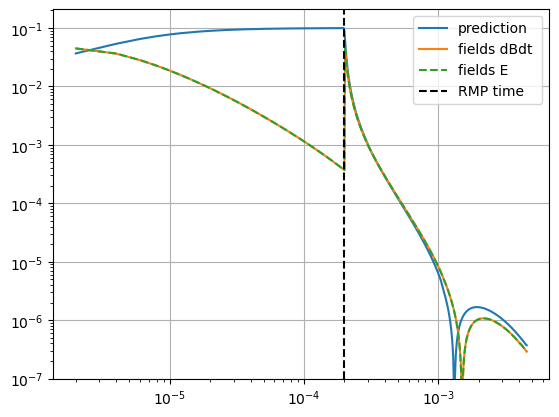

In [15]:

#dBdt = np.sum(dBdt,axis=0).T
print(dBdt.shape)
#plt.semilogx(time_emip,n_turns*dBdt.T, label="fields") 
plt.loglog(time_emip,np.abs(dpred_emip), label="prediction")
plt.loglog(time_emip,np.abs(n_turns*dBdt_area), label="fields dBdt ") 
plt.loglog(time_emip,np.abs(n_turns*e_edge_length), linestyle="--",label="fields E")
rmp_time = 200e-6
plt.ylim(bottom=1e-7)
plt.axvline(rmp_time, color='k', linestyle='--', label="RMP time")
plt.grid(True)
plt.legend()

(1e-07, 0.001519291078694181)

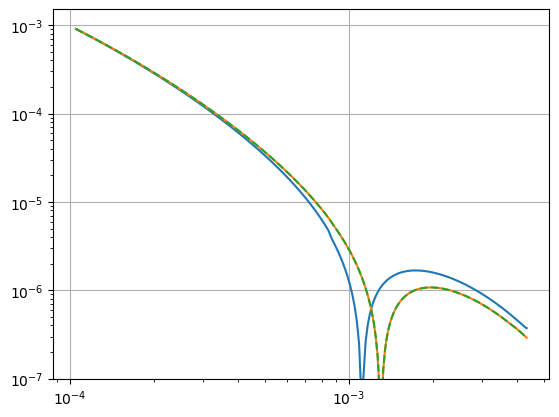

In [16]:
ind_plot = (time_emip > rmp_time + 1e-4 +eps)
plt.loglog(time_emip[ind_plot]-rmp_time,np.abs(dpred_emip[ind_plot]), label="prediction")
plt.loglog(time_emip[ind_plot]-rmp_time,np.abs(n_turns*dBdt_area[ind_plot]), label="fields dBdt ") 
plt.loglog(time_emip[ind_plot]-rmp_time,np.abs(n_turns*e_edge_length[ind_plot]),linestyle="--", label="fields E")
plt.grid(True)
plt.ylim(bottom=1e-7)

In [17]:
dpred_emip = n_turns*e_edge_length

# Time Step

In [18]:
#rx_times = [np.linspace(np.log10(e-5), np.log10(8e-3), 20)]
tstrt, tend = 1e-5, 1e-2
print(f'Peak time = {peak_time(z=tx_radius, sigma=con_sea):.2e} sec')

print(f'Earliest time = {tstrt:.2e} sec, \
Diffusion Depth: {diffusion_distance(sigma=con_sea, time=tstrt):.2e}')

print(f'''Latest time = {tend:.2e} sec, \
Diffusion Depth: {diffusion_distance(sigma=con_sea, time=tend):.2e}''')

# Compute transition time from Early to late time
print(f'Transition time between early and late time = {(mu_0 * (tx_radius**2) * con_sea) / 4:.5e}')

EarlyTime = mu_0 * con_sea * (tx_radius**2) / 4

Peak time = 2.45e-06 sec
Earliest time = 1.00e-05 sec, Diffusion Depth: 2.30e+00
Latest time = 1.00e-02 sec, Diffusion Depth: 7.28e+01
Transition time between early and late time = 3.67500e-06


# empymod implication

In [19]:
depth =  tx_height + np.r_[0, thick_target]
print(depth)

[ 0.49366589 30.49366589]


In [20]:
## Calculate time with 1/4 of the time steo for recored time steps
## use sampling frequency as 50kHz, ramp time of 200us (K. Nakayama and A. Saito,	2016)
tstrt, tend = 1e-4, 4e-3
logstep = 1/20
times_empymod = WISTEM_SP_sim.times_rec

print(len(times_empymod))
print(times_empymod[:3], times_empymod[-3:])
filt_rmp = WISTEM_SP_sim.filter_linear_rmp()
windows_cen, windows_strt, windows_end=WISTEM_SP_sim.get_window_log(
    logstep=logstep,tstart=tstrt ,tend=tend)
Window_mat = WISTEM_SP_sim.get_window_matrix(times=times_empymod)
print(Window_mat.shape)

1000
[5.0e-06 1.0e-05 1.5e-05] [0.00499  0.004995 0.005   ]
(32, 1000)


In [21]:
# emoymod model to simulate WISTEM setting
# Note that it simulate only dBdt field at center of the transmitter loop
# User should multiply by area of the loop to get EMF(V/A)
empymod_model_bdple = {
    # simulate each bipole of four side of the transmitter loop
    'src': [   tx_side/2, tx_side/2, 0,tx_side/2, tx_depth,  tx_depth], 
    # receiver at the center of the transmitter loop
    'freqtime' : times_empymod,
    'rec': [ 0,0,tx_depth,0,90], # dBzdt at x,y,z,azimuth,dip
    'depth': depth,
#    'freqtime': time_empymod,
    'signal': 0, # 0: impulse or dBdt, 1: Stepoff or B field
    'msrc' : False, # Electric source
    'mrec' : True, # Magnetic receiver
    'strength': n_turns* tx_surface* 8* mu_0,  
    'srcpts' : 3,  # Three works for the momtent, maybe worth seeking other number
    'verb': 0, # put 4 for more information
     # Setting xdirect=True can help, as direct field is then computed analytically in f-domain
    'xdirect': True,
}

In [22]:
nlayer = 1
DeepSea_TEMIP=empymod_IPinv(model_base=empymod_model_bdple, nlayer=nlayer)
DeepSea_TEMIP.fix_sea_basement(
    res_sea=res_sea, res_base=res_base,
    chg_sea=eta_sea, chg_base=eta_base,
    tau_sea=tau_sea, tau_base=tau_base,
    c_sea=c_sea, c_base=c_base
    )



(array([[0., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 0.]]),
 array([-1.09861229,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -4.60517019,  0.        , -4.60517019,  0.6       ,
         0.        ,  0.6       ]))

In [23]:
res = rho0_target * np.ones(nlayer)
m_r = np.log(res)
m = eta_target * np.ones(nlayer)
m_m = m 
m_t = np.log(tau_target)*np.ones(nlayer)
m_c = c_target*np.ones(nlayer)
mvec = np.r_[m_r, m_m,m_t,m_c]
print(mvec)
print(DeepSea_TEMIP.get_ip_model(mvec))

[-1.89711998  0.3        -6.90775528  0.8       ]
{'res': array([0.33333333, 0.15      , 1.        ]), 'rho_0': array([0.33333333, 0.15      , 1.        ]), 'm': array([0. , 0.3, 0. ]), 'tau': array([0.01 , 0.001, 0.01 ]), 'c': array([0.6, 0.8, 0.6]), 'func_eta': <bound method empymod_IPinv.pelton_et_al of <masa_utils.empymod_IPinv object at 0x000002DBB60EA670>>}


In [24]:
dpred_step= DeepSea_TEMIP.predicted_data(mvec)
DeepSea_TEMIP.cut_off = smp_freq/2.0
print(f"cutoff frequency: {DeepSea_TEMIP.cut_off}")
dpred_LPF = DeepSea_TEMIP.predicted_data(mvec)
DeepSea_TEMIP.filt_curr = filt_rmp
dpred_rmp = DeepSea_TEMIP.predicted_data(mvec)
DeepSea_TEMIP.window_mat=Window_mat
dpred_window = DeepSea_TEMIP.predicted_data(mvec)
nD=DeepSea_TEMIP.nD

cutoff frequency: 25000.0


In [25]:
PL_decay = PsuedoLog(
    logmin=1e-7,
    linScale=0.2,
    logminx=1e-4,
    linScalex=0.2)

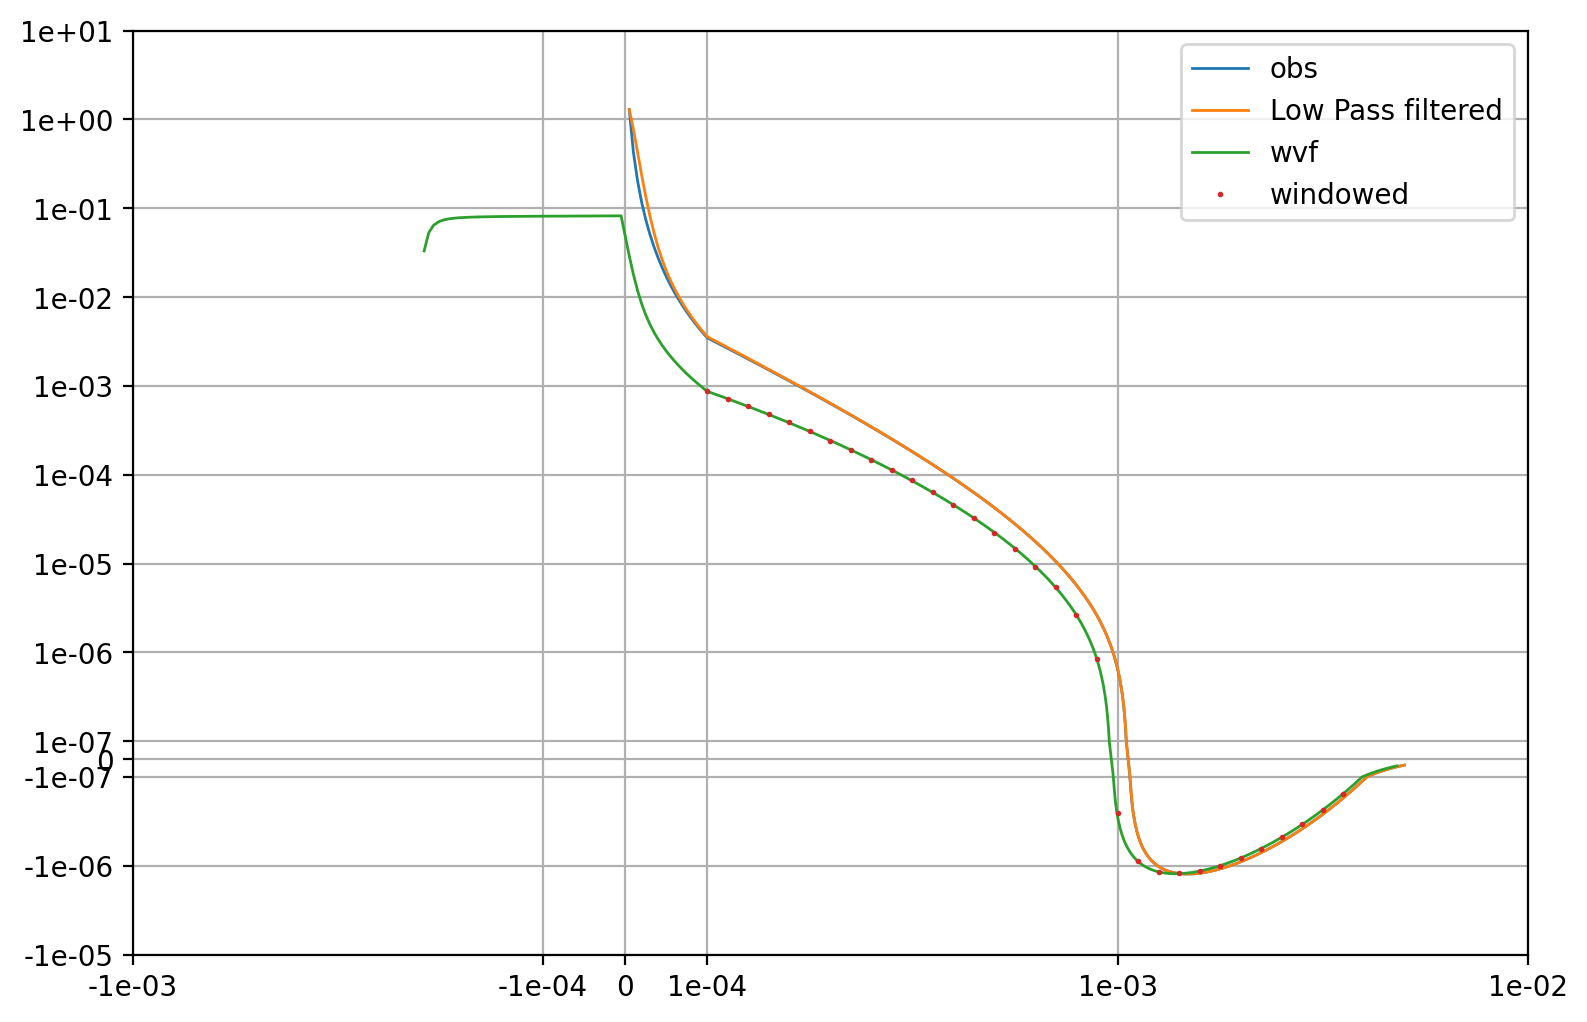

In [26]:
fig, ax= plt.subplots(1,1, figsize=(9,6), dpi=200)
ax=PL_decay.plpl_plot(
     x=times_empymod,y=dpred_step , linestyle="-",label="obs", color="C0",ax=ax)
ax=PL_decay.plpl_plot(
     x=times_empymod,y=dpred_LPF , linestyle="-",label="Low Pass filtered", color="C1",ax=ax)
ax=PL_decay.plpl_plot(
     x=times_empymod-rmp_time,y=dpred_rmp , linestyle="-",label="wvf", color="C2",ax=ax)
ax=PL_decay.plpl_plot(
     x= windows_cen-rmp_time,y=dpred_window , marker="o",linestyle="",label="windowed", color="C3",ax=ax)
ax= PL_decay.pl_axes(ax)
ax = PL_decay.pl_axes_x(ax)
#for ax in ax:
ax.grid()
ax.legend()


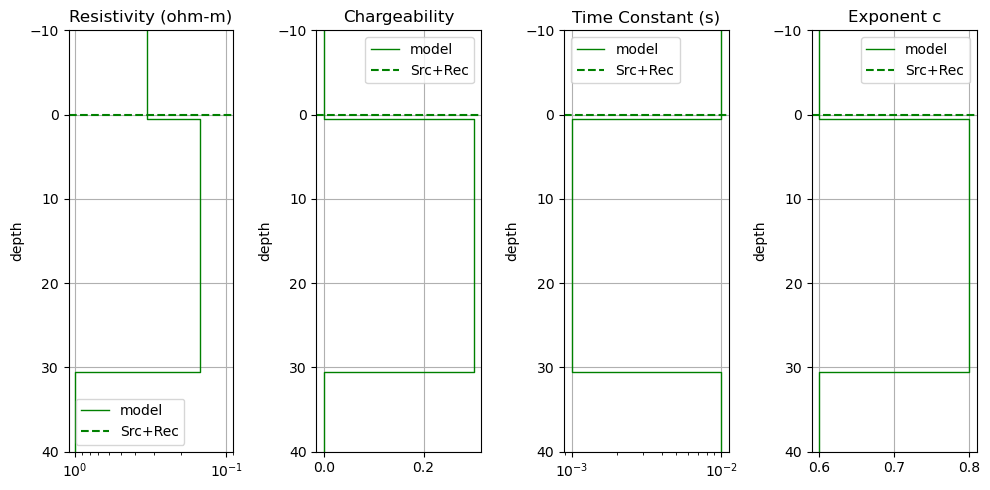

In [27]:
fig, ax = plt.subplots(1,4, figsize=(10,5))

ax=DeepSea_TEMIP.plot_IP_par(mvec=mvec, ax=ax, color="g",label="model")
ax[0].set_xlim([1.1,0.09])

for i in range(4):  # Iterate over rows
    ax[i].set_ylim([40, -10])
    ax[i].axhline(tx_depth,color="g", linestyle="--", label="Src+Rec")
    ax[i].set_ylabel('depth')
    if i== 0 or i ==2:
        ax[i].set_xscale("log")
    else:
        ax[i].set_xscale("linear")
    ax[i].set_ylabel('depth')
    ax[i].legend()
    ax[i].grid()

plt.tight_layout()
plt.show()


# compare simpegemip and empymod

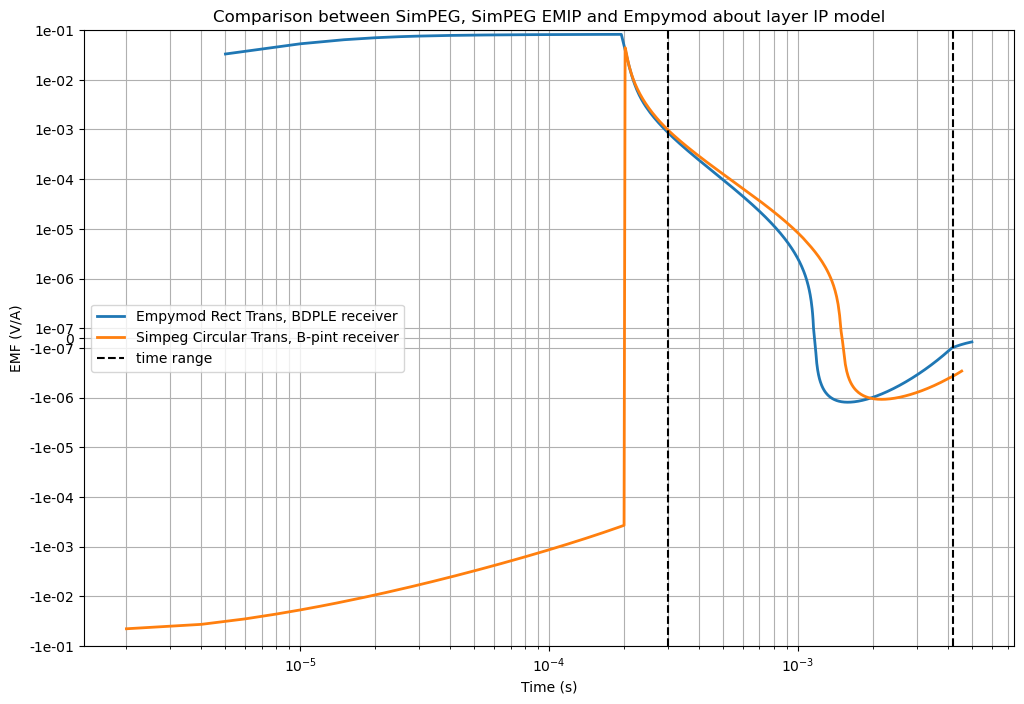

In [28]:
fig, ax = plt.subplots(1,1, figsize=(12,8))

# #plt.loglog(time_emip, data_emip, '--k')
ax = PL_decay.semiply(x=times_empymod, y=dpred_rmp,ax=ax,
    linestyle="-",linewidth= 2, label="Empymod Rect Trans, BDPLE receiver", color="C0")

ax = PL_decay.semiply(x=time_emip,y=dpred_emip,ax=ax,
    linestyle="-",linewidth= 2, label="Simpeg Circular Trans, B-pint receiver", color="C1")

ax = PL_decay.pl_axes(ax)
ax.axvline(rmp_time+1e-4, color='k', linestyle='--', label='time range')
ax.axvline(rmp_time+4e-3, color='k', linestyle='--')  # No need to repeat the label

plt.legend()
plt.ylabel('EMF (V/A)')
plt.xlabel('Time (s)')
plt.grid(True, which='both')
ax.set_title("Comparison between SimPEG, SimPEG EMIP and Empymod about layer IP model")
plt.show()

In [29]:
tstrt_plot, tend_plot = 1e-4, 1e-2

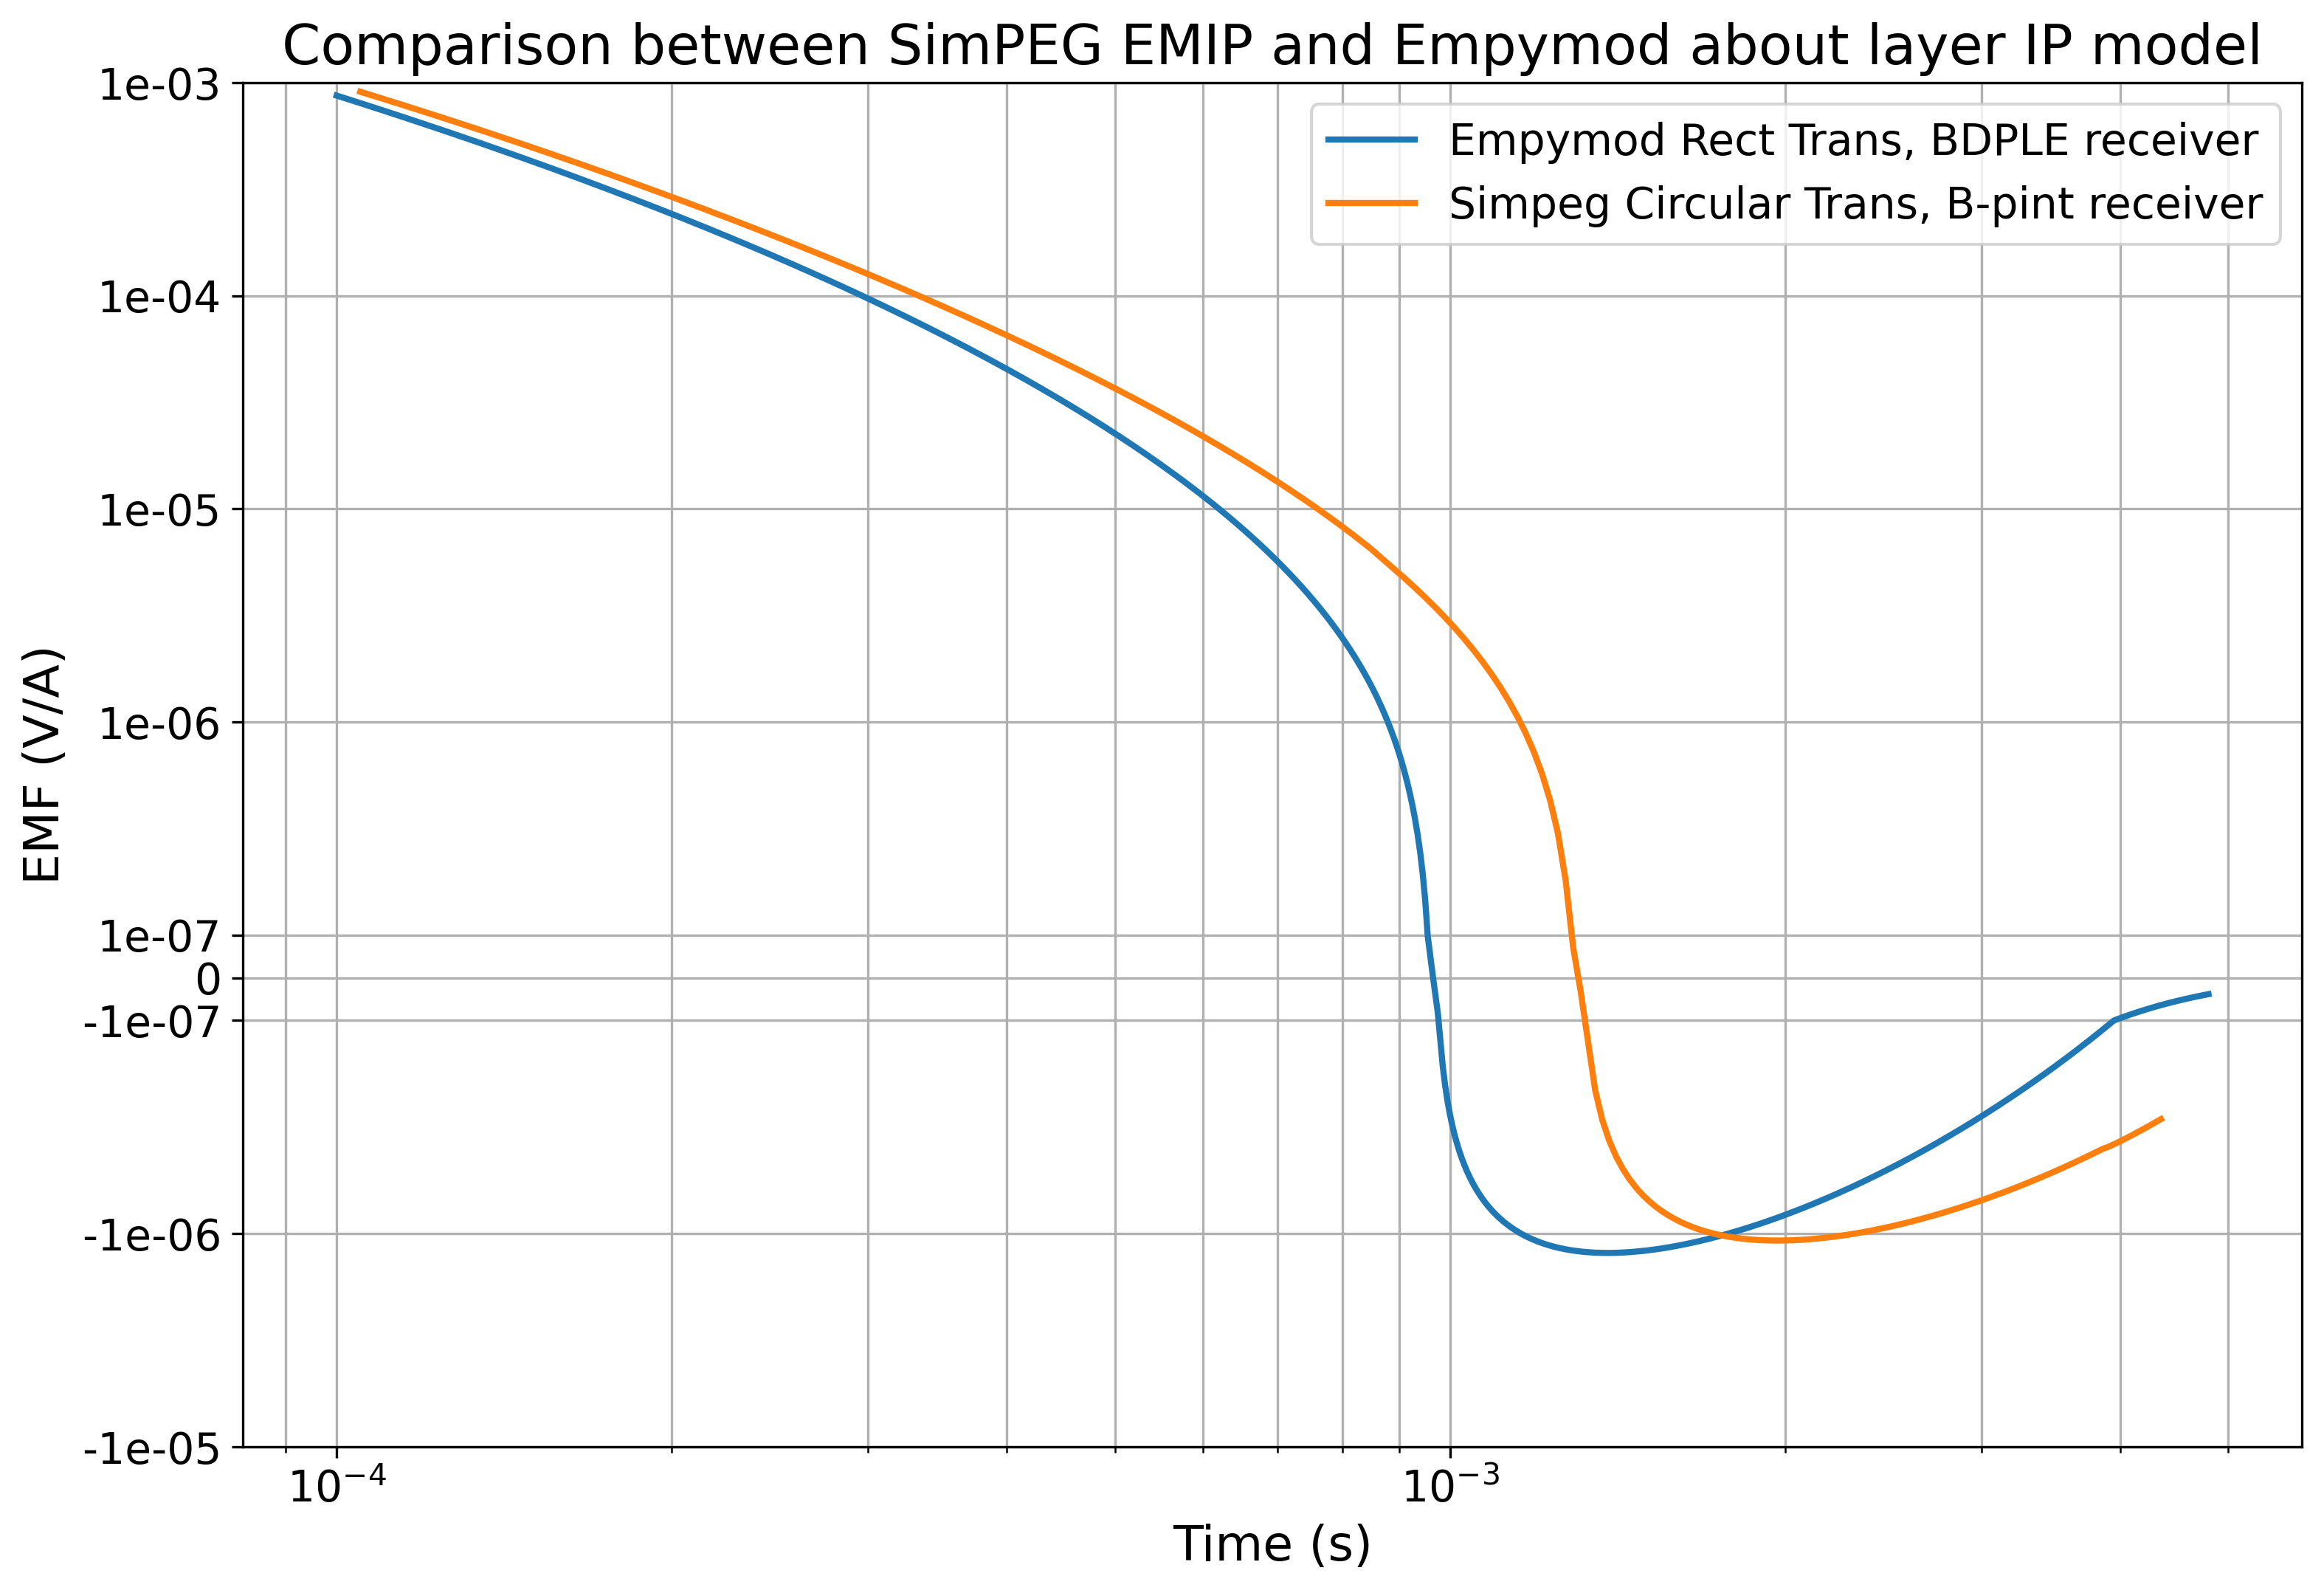

In [30]:
fig, ax = plt.subplots(1,1, figsize=(12,8),dpi=300)
# #plt.loglog(time_emip, data_emip, '--k')
ind_plot = (times_empymod >= tstrt_plot+rmp_time) & (times_empymod <= tend_plot+rmp_time)
ax = PL_decay.semiply(x=times_empymod[ind_plot]-rmp_time, y=dpred_rmp[ind_plot],ax=ax,
    linestyle="-",linewidth= 2, label="Empymod Rect Trans, BDPLE receiver", color="C0")
ind_plot = (time_emip >= tstrt_plot+rmp_time) & (time_emip <= tend_plot+rmp_time)
ax = PL_decay.semiply(x=time_emip[ind_plot]-rmp_time,y=dpred_emip[ind_plot],ax=ax,
    linestyle="-",linewidth= 2, label="Simpeg Circular Trans, B-pint receiver", color="C1")

ax = PL_decay.pl_axes(ax)

plt.legend(fontsize=14)  # Increase legend font size
plt.ylabel('EMF (V/A)', fontsize=16)
plt.xlabel('Time (s)', fontsize=16)
plt.grid(True, which='both')
ax.set_title("Comparison between SimPEG EMIP and Empymod about layer IP model", fontsize=18)

# Increase tick parameters for both axes
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=12)

# Fields Plots

In [31]:
tstrt_plot, tend_plot = 1e-4, 6e-3
ind_plot = (time_emip > +eps + rmp_time +tstrt_plot) & (time_emip < tend_plot + rmp_time)
print(ind_plot.sum())
nind_noplot= len(time_emip) - ind_plot.sum()
print(nind_noplot)

310
150


In [32]:
def plot_seafloor(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(8,5))
    ax.axhline(-tx_height, color='k', linestyle='--',lw=1)
    return ax

def plot_layer(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(8,5))
    ax.axhline(-tx_height, color='k', linestyle='--',lw=1)
    ax.axhline(-tx_height-thick_target, color='k', linestyle='--',lw=1)
    return ax



In [33]:
def plot_sim(time_ind=1, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(8,5))
#    ind_plot = time_emip > eps + rmp_time 
    ind_plot = time_emip > eps + rmp_time + tstrt  
    ax = PL_decay.semiply(x=time_emip[ind_plot]-rmp_time,y=dpred_emip[ind_plot]
      ,ax=ax,linestyle="-",linewidth= 2, color="C0"
      , label="Simpeg Circular Trans, B-pint receiver"
      )    
    if time_ind >= (len(time_emip) - ind_plot.sum()) :
        ax = PL_decay.semiply(x=time_emip[time_ind]-rmp_time,y=dpred_emip[time_ind]
            ,ax=ax,linestyle="",marker="o",markersize=6, color="C1"
            , label="Simpeg Circular Trans, B-pint receiver"
            )
    PL_decay.pl_axes(ax)
    ax.set_xlim(left=8e-5)   
    ax.set_ylabel('EMF (V/A)')
    ax.set_xlabel('Time (s)')
    ax.grid(True)
    ax.set_title(f'Simulation time: {time_emip[time_ind]-rmp_time:10.2e} s')
    return ax

In [34]:
def plot_fields_e(time_ind=1, range_x=[-40,40], range_y=[-40,20],zoom=False, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(8,5))
    min_field, max_field = None, None
    v_type = "CC"
    view_type="real"    
    plotme = fields_saved[:, 0, time_ind]
    plotme = mesh.average_edge_y_to_cell * plotme
    max_field = np.abs(plotme).max() #use to set colorbar limits
    mirror_data = -plotme

    if zoom:
        ind_range = (
        (mesh.cell_centers[:, 2] <= max(range_y) ) &
        (mesh.cell_centers[:, 2] >= min(range_y) ) &
        (mesh.cell_centers[:, 0] <= max(range_x) ) )
        plotrange = plotme[ind_range]
        max_field = np.abs(plotrange).max() #use to set colorbar limits

    norm=Normalize(vmin=-max_field, vmax=max_field)
    cb = plt.colorbar(mesh.plot_image(
        plotme, 
        v_type= v_type, view=view_type, mirror_data=mirror_data,
        range_x=range_x, range_y=range_y,
        pcolor_opts={'norm': norm}, stream_opts= {'color': 'w'}, 
        stream_threshold=min_field, mirror=True, ax=ax,
    )[0], ax=ax,format='%.1e')
    ax=plot_seafloor(ax)  
#    ax=plot_layer(ax)  
#    ax=plot_mound_outline(ax)  
    # plot the source locations 
    ax.plot(np.r_[tx_radius,-tx_radius],np.r_[0,0],"ko-", markersize=3)

    ax.set_xlim(range_x)
    ax.set_ylim(range_y)
    ax.set_aspect('equal')
    ax.set_xlabel('x (m)')
    ax.set_ylabel('z (m)')
    ax.set_title(f'E-field ($V/m$), time: {time_clc[time_ind]-rmp_time:10.2e} s')
    return ax


In [35]:
def plot_fields_dbdt(time_ind=1, range_x=[-40,40], range_y=[-40,20],zoom=False, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(8,5))
    # Calculate 
    v_type, view_type="F", "vec"
    plot_dbdt = mesh.edge_curl * fields_saved[:,0 , time_ind]
    mirror_data = None
    max_field = np.abs(plot_dbdt).max() #use to set colorbar limits

    if zoom:
        ind_range = (
        (mesh.faces[:, 2] <= max(range_y) ) &
        (mesh.faces[:, 2] >= min(range_y) ) &
        (mesh.faces[:, 0] <= max(range_x) ) )
        max_field = np.abs(plot_dbdt[ind_range]).max() #use to set colorbar limits

    cb_range = 20  # dynamic range of colorbar
    min_field = max_field/cb_range
    norm=Normalize(vmin= min_field, vmax=max_field)
    cb = plt.colorbar(mesh.plot_image(
        plot_dbdt, 
        v_type= v_type, view=view_type, mirror_data=mirror_data,
        range_x=range_x, range_y=range_y,
        pcolor_opts={'norm': norm}, stream_opts= {'color': 'w'}, 
        stream_threshold=min_field, mirror=True, ax=ax,
    )[0], ax=ax,format='%.1e')
    ax=plot_seafloor(ax)  
#    ax=plot_layer(ax)  
#    ax=plot_mound_outline(ax)  
    # plot the source locations 
    ax.plot(np.r_[tx_radius,-tx_radius],np.r_[0,0],"ko-", markersize=3)

    ax.set_xlim(range_x)
    ax.set_ylim(range_y)
    ax.set_aspect('equal')
    ax.set_xlabel('x (m)')
    ax.set_ylabel('z (m)')
    ax.set_title(f'dBdt, time: {time_clc[time_ind]-rmp_time:10.2e} s')
    return ax


In [36]:
IPmodel_fft = InducedPolarization(
    con8=con8_target,eta=eta_target, tau=tau_target, c=c_target
    )
log2nfreq=14
con_form=True
freq_tau=IPmodel_fft.get_frequency_tau(log2nfreq=log2nfreq)
times_tau, data_tau = IPmodel_fft.pelton_fft(con_form=con_form, freq=freq_tau)
time_step = times_tau[1] - times_tau[0]
data_tau *= time_step
logmin=1e-3
linScale=0.2
logminx=1e-4
linScalex=0.1
PL_fft = PsuedoLog(
        logmin=logmin, #10.**np.floor(np.log10(data_tau[0])-3.),
        linScale=linScale, #0.2,
        logminx=logminx, # 10.**np.ceil(np.log10(time_step)),
        linScalex=linScalex)

log2(len(freq)) 14.0 considering tau


In [37]:
def plot_con_t(time_ind=1,  ax=None):
    # Assuming `cc` is your complex array, `freq` is the frequency array, and `tau` is defined
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(8, 6))
    
    ind_plot = (times_tau > eps ) & (times_tau <rmp_time+ tend_plot)

    ax = PL_fft.plpl_plot(x=times_tau[ind_plot], y=data_tau[ind_plot], ax=ax, 
                        linewidth=2.0, label=r"$\sigma(t) \, dt$", color="C0")
    ax = PL_fft.plpl_plot(x=np.r_[0,times_tau[0]], y=np.r_[0,data_tau[0]], ax=ax, 
                    linewidth=2.0,  color="C0", marker='o', markersize=4) 
    if time_emip[time_ind] > rmp_time:
        ind_conv = (times_tau > eps) & (times_tau < time_emip[time_ind] -rmp_time)
        ax = PL_fft.plpl_plot(x=times_tau[ind_conv], y=data_tau[ind_conv], ax=ax, 
                        linewidth=2.0,  label='convolved time', color="C1") 
        ax = PL_fft.plpl_plot(x=np.r_[0,times_tau[0]], y=np.r_[0,data_tau[0]], ax=ax, 
                        linewidth=2.0, color="C1", marker='o', markersize=4) 
    PL_fft.pl_axes(ax=ax)
    PL_fft.pl_axes_x(ax=ax)
    ax.set_xlim(right=PL_fft.pl_value(tend_plot+rmp_time,logmin=logminx,linScale=linScalex))
    ax.set_title(f"""Layer Conductivity as function of time""")
    ax.grid(which='both')
    ax = PL_fft.pl_axvline(ax=ax, x=tau_target,label=r'$\tau$')
    ax.set_xlabel('time(sec)')
    ax.legend()
    return ax 

In [38]:
def plot_con_t(time_ind=1, ax=None):
    # Assuming `cc` is your complex array, `freq` is the frequency array, and `tau` is defined
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    ind_plot = (times_tau > eps) & (times_tau < rmp_time + tend_plot)

    # Plot the main curve
    ax = PL_fft.plpl_plot(x=times_tau[ind_plot], y=data_tau[ind_plot], ax=ax, 
                          linewidth=2.0, label=r"$\sigma(t) \, dt$", color="k")
    ax = PL_fft.plpl_plot(x=np.r_[0,times_tau[0]], y=np.r_[0,data_tau[0]], ax=ax, 
                    linewidth=2.0,  color="k", marker='o', markersize=4)  
    # Add a secondary curve (if needed)
    if time_emip[time_ind] > rmp_time:
        ind_conv = (times_tau > eps) & (times_tau < time_emip[time_ind] -rmp_time)
        ax = PL_fft.plpl_plot(x=times_tau[ind_conv], y=data_tau[ind_conv], ax=ax, 
                        linewidth=2.0,  color="C1", label="Convolved times") 
        ax = PL_fft.plpl_plot(x=np.r_[0,times_tau[0]], y=np.r_[0,data_tau[0]], ax=ax, 
                        linewidth=2.0, color="C1", marker='o', markersize=4) 
        # Fill the area under the secondary curve
        ax.fill_between(
            PL_fft.pl_value(times_tau[ind_conv],logmin=logminx,linScale=linScalex),
            PL_fft.pl_value(data_tau[ind_conv],logmin=logmin,linScale=linScale),
             0, color="C1", alpha=0.3)
    
    # Set axes and titles
    PL_fft.pl_axes(ax=ax)
    PL_fft.pl_axes_x(ax=ax)
    ax.set_xlim(right=PL_fft.pl_value(tend_plot + rmp_time, logmin=logminx, linScale=linScalex))
    ax.set_title("Layer Conductivity as Function of Time")
    ax.grid(which='both')
    ax = PL_fft.pl_axvline(ax=ax, x=tau_target, label=r'$\tau$')
    ax.set_xlabel('Time (sec)')
    ax.legend()
    return ax


In [ ]:
def plot_fields_widgets(time_ind=nind_noplot): 

    fig, ax = plt.subplots(2,2, figsize=(11,6))
    range_x, range_y = [-15,15], [-12,6]

    ax[0,0] = plot_con_t(time_ind=time_ind,ax=ax[0,0])
    ax[0,1] = plot_fields_e(time_ind=time_ind,
         range_x=range_x, range_y=range_y,zoom=True,ax=ax[0,1])
    ax[1,0] =  plot_sim(time_ind=time_ind,ax=ax[1,0])
    ax[1,1] = plot_fields_dbdt(time_ind=time_ind,
         range_x=range_x, range_y=range_y,zoom=True,ax=ax[1,1])
    plt.tight_layout()
    plt.show()

ipywidgets.interact(
    plot_fields_widgets, 
    time_ind=ipywidgets.IntSlider(min=nind_noplot, max=ntime-1,continuous_update=True), 
)

interactive(children=(IntSlider(value=150, description='time_ind', max=459, min=150), Output()), _dom_classes=…

<function __main__.plot_fields_widgets(time_ind=150)>

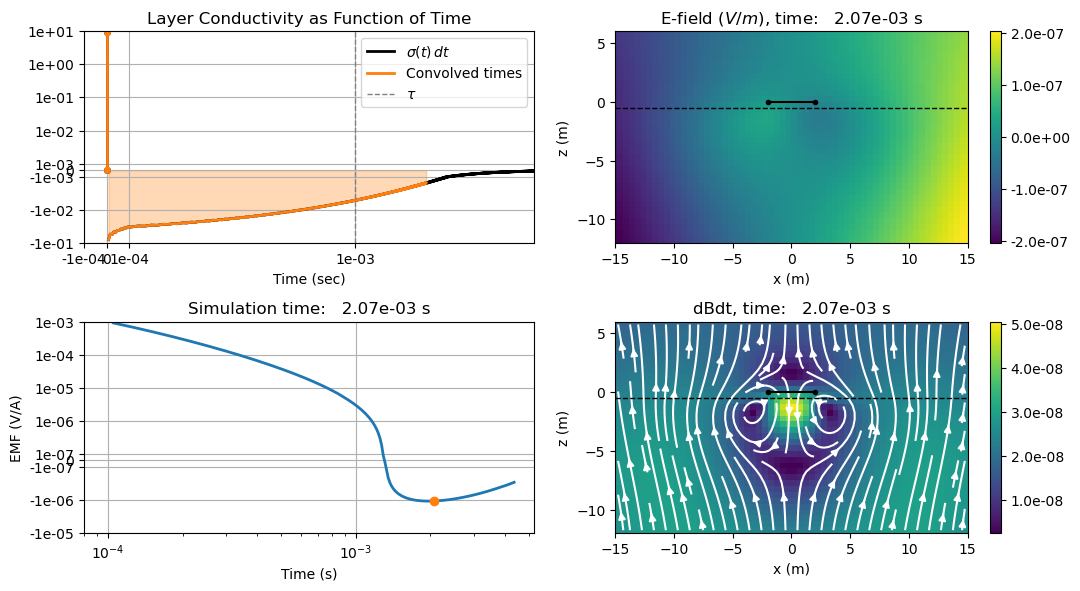

In [ ]:
plot_fields_widgets(time_ind=360)
plt.savefig("14_Validation_layerIP_rmp.png", dpi=300, bbox_inches='tight')

# Create Animation

In [41]:
def save_all_fields_images(index_list, output_folder='images'):
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    for ind_save in index_list:
        # Create a new figure and axes for each time index
        fig, ax = plt.subplots(1,1,figsize=(10, 6))
        
        # Plot the fields for the current time index
        plot_fields_widgets(time_ind=ind_save)

        # Create a filename with zero padding (e.g., 001.png, 002.png)
        filename = f'{ind_save:03d}.png'
        # Save the figure to the output folder
        filepath = os.path.join(output_folder, filename)
        plt.savefig(filepath, format='png', dpi=300, bbox_inches='tight', pad_inches=0.1)
        
        # Close the figure to avoid display issues and free up memory
        plt.close(fig)

In [42]:
#index_list = np.arange(1, len(time_clc), 1)
index_list = np.arange(nind_noplot, ntime, 10)
#index_list = np.arange(1,10, 1)

output_folder = 'images'
## set matplot lib not to show all images for VS code 
matplotlib.use('Agg')      

save_all_fields_images(index_list, output_folder=output_folder)
%matplotlib inline
## set matplot lib not to show all images for VS code 


C:\Users\81805\AppData\Local\Temp\ipykernel_22588\1241955423.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
C:\Users\81805\AppData\Local\Temp\ipykernel_22588\1241955423.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
C:\Users\81805\AppData\Local\Temp\ipykernel_22588\1241955423.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
C:\Users\81805\AppData\Local\Temp\ipykernel_22588\1241955423.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
C:\Users\81805\AppData\Local\Temp\ipykernel_22588\1241955423.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
C:\Users\81805\AppData\Local\Temp\ipykernel_22588\1241955423.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
C:\Users\81805\AppData\Local\Temp\ipykernel_22588\1241955423.py:13: Us

In [43]:
def images_to_gif(image_folder, output_gif, duration=1000, resize=(300, 180)):
    # Get all the image files in the folder
    image_files = sorted([f for f in os.listdir(image_folder) if f.endswith('.png') or f.endswith('.jpg')])

    # Open and resize the images
    images = [Image.open(os.path.join(image_folder, img)).resize(resize, Image.Resampling.LANCZOS) for img in image_files]
    
    # Save the images as an animated GIF loop 0: infinite loop, 1: loop once
#    images[0].save(output_gif, save_all=True, append_images=images[1:], optimize=False, duration=duration, loop=0)
    images[0].save(output_gif, save_all=True, append_images=images[1:], optimize=False, duration=duration, loop=1)


In [44]:
# Provide the path to the input image folder, output video file, and desired duration (slower)
input_folder = r"images"
output_file = r"14_LayerIP_rmp_con_t_resmp.gif"

duration = 1000/3  # ms per frame
resize = (1100, 600)  # New resolution (width, height)

# Call the function to convert the images to a GIF
images_to_gif(image_folder=input_folder, output_gif=output_file, 
  duration=duration, resize=resize)

In [45]:
def delete_all_images(folder_path):
    # Check if the folder exists
    if not os.path.exists(folder_path):
        raise ValueError(f"The folder {folder_path} does not exist.")
    
    # Get the list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))]
    
    # Delete each image file
    for image_file in image_files:
        file_path = os.path.join(folder_path, image_file)
        try:
            os.remove(file_path)
            print(f"Deleted {file_path}")
        except Exception as e:
            print(f"Error deleting {file_path}: {e}")

# Provide the path to the folder containing images
image_folder = 'images'

# Call the function to delete all images in the folder
delete_all_images(image_folder)

Deleted images\150.png
Deleted images\160.png
Deleted images\170.png
Deleted images\180.png
Deleted images\190.png
Deleted images\200.png
Deleted images\210.png
Deleted images\220.png
Deleted images\230.png
Deleted images\240.png
Deleted images\250.png
Deleted images\260.png
Deleted images\270.png
Deleted images\280.png
Deleted images\290.png
Deleted images\300.png
Deleted images\310.png
Deleted images\320.png
Deleted images\330.png
Deleted images\340.png
Deleted images\350.png
Deleted images\360.png
Deleted images\370.png
Deleted images\380.png
Deleted images\390.png
Deleted images\400.png
Deleted images\410.png
Deleted images\420.png
Deleted images\430.png
Deleted images\440.png
Deleted images\450.png


In [46]:
eta_t_saved = np.load("14_layer_eta_t.npy")
print(eta_t_saved.shape)

(460, 6)


In [47]:
eta_times0= eta_t_saved[:,0]
eta_times1= eta_t_saved[:,1]
eta_time_steps = eta_t_saved[:,2]
eta_petaI = eta_t_saved[:,3]
eta_petaoff = eta_t_saved[:,4]
eta_kappa = eta_t_saved[:,5]

In [48]:
PL_eta= PsuedoLog(
    logmin=1e-7,
    linScale=0.2,
    logminx=1e-5,
    linScalex=0.2)

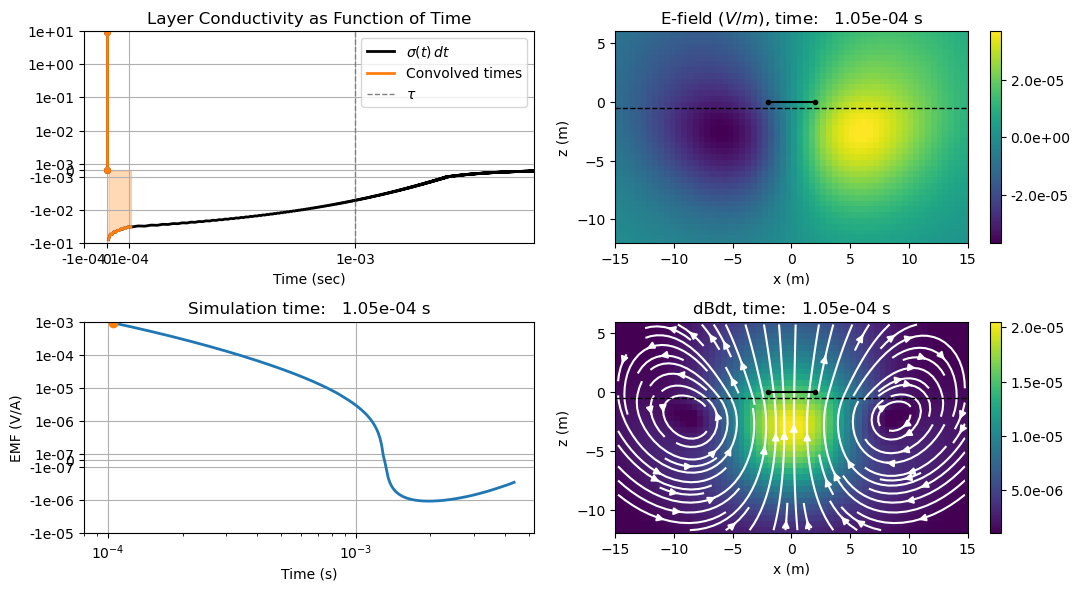

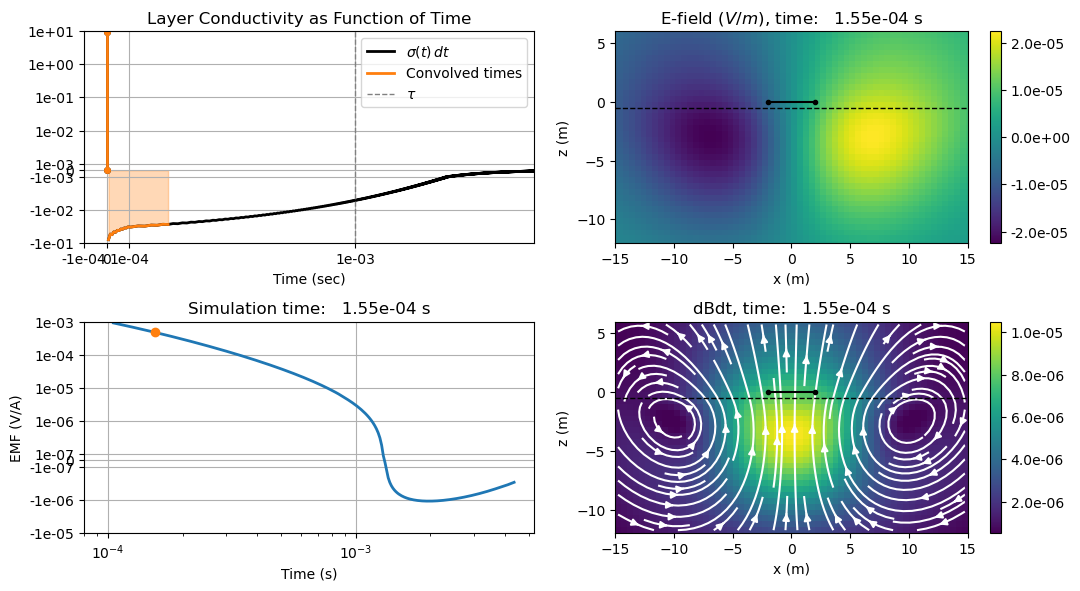

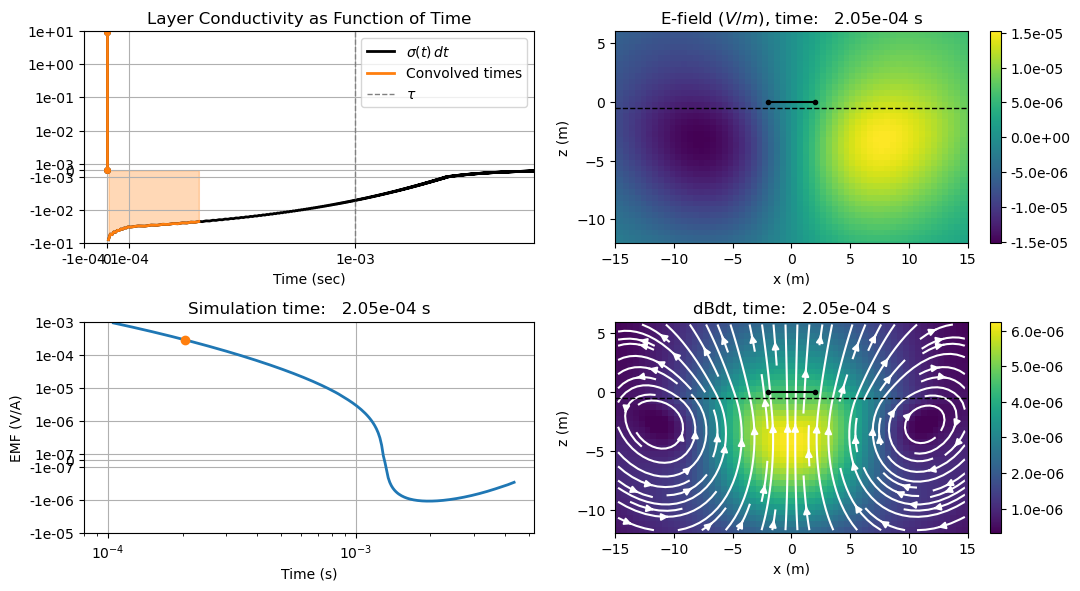

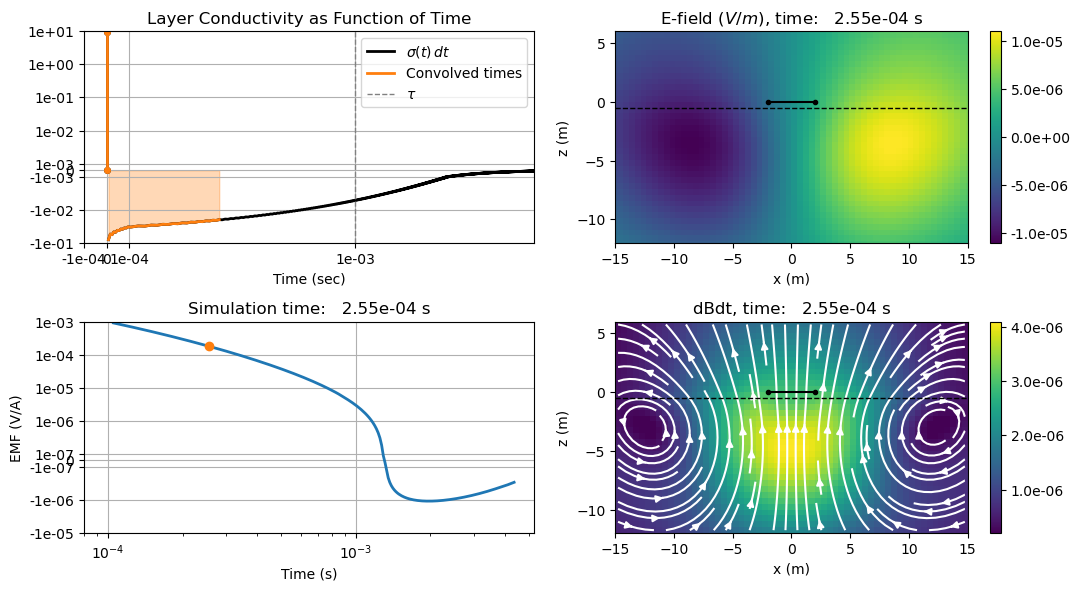

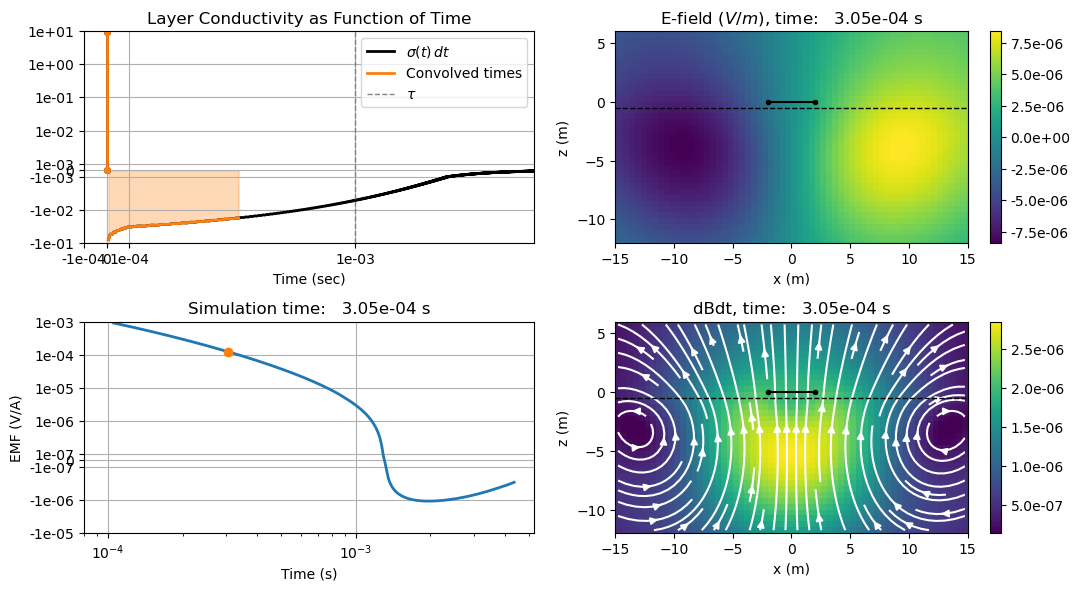

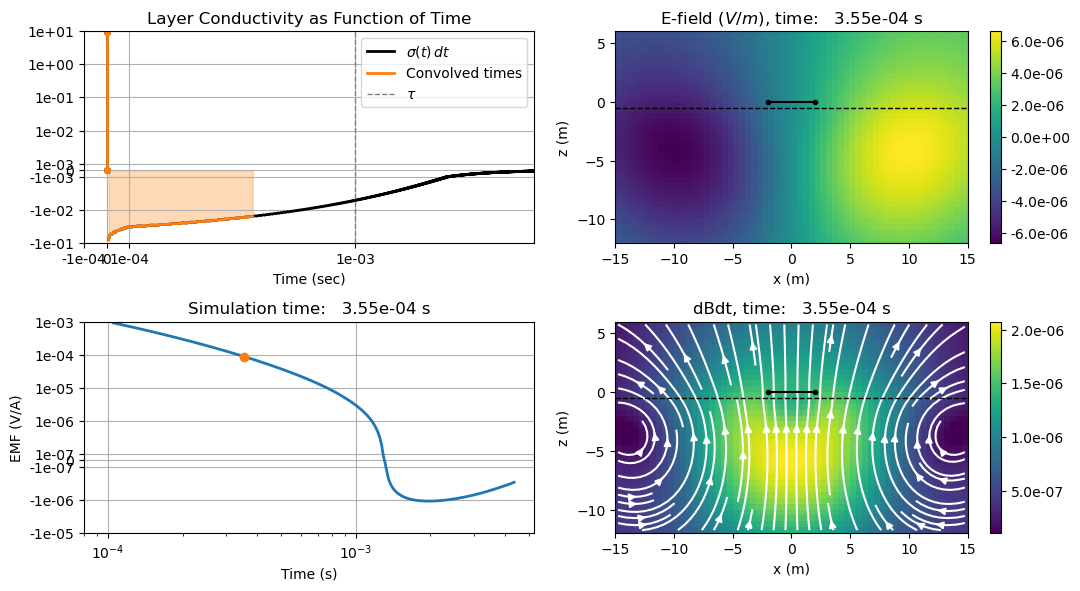

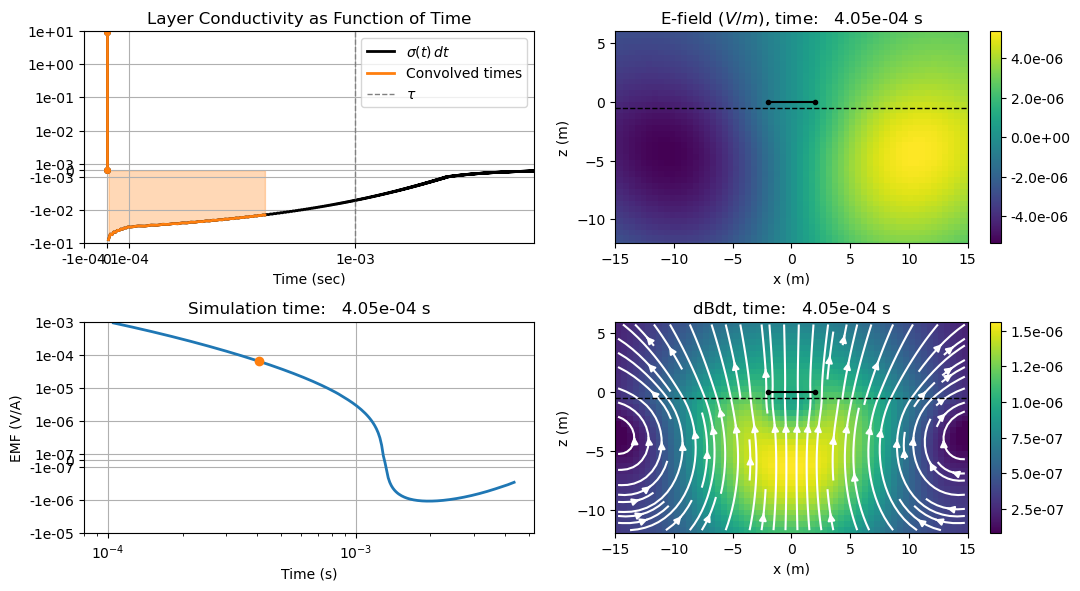

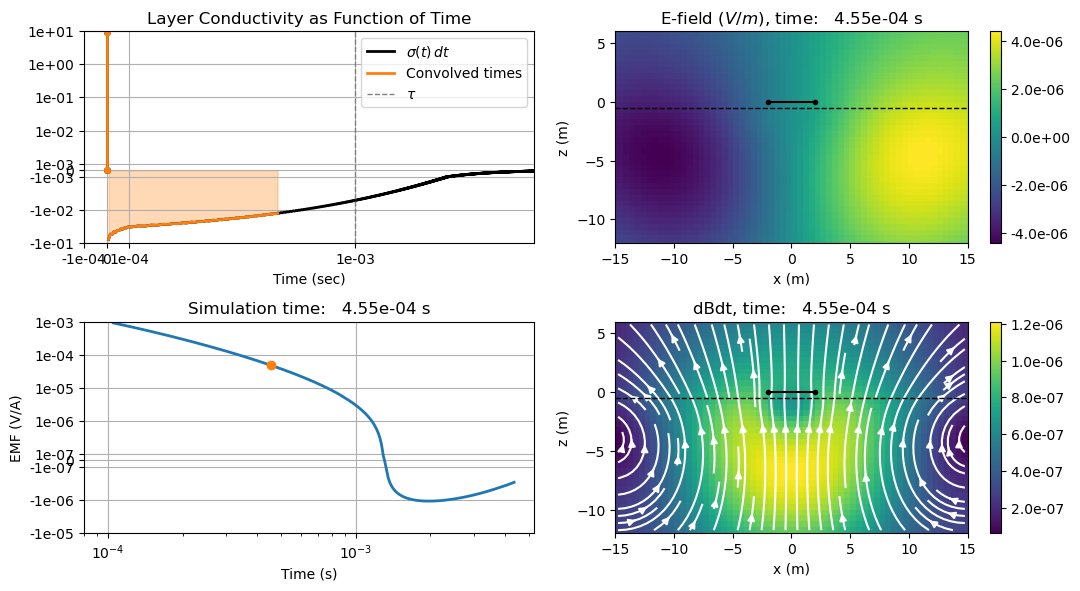

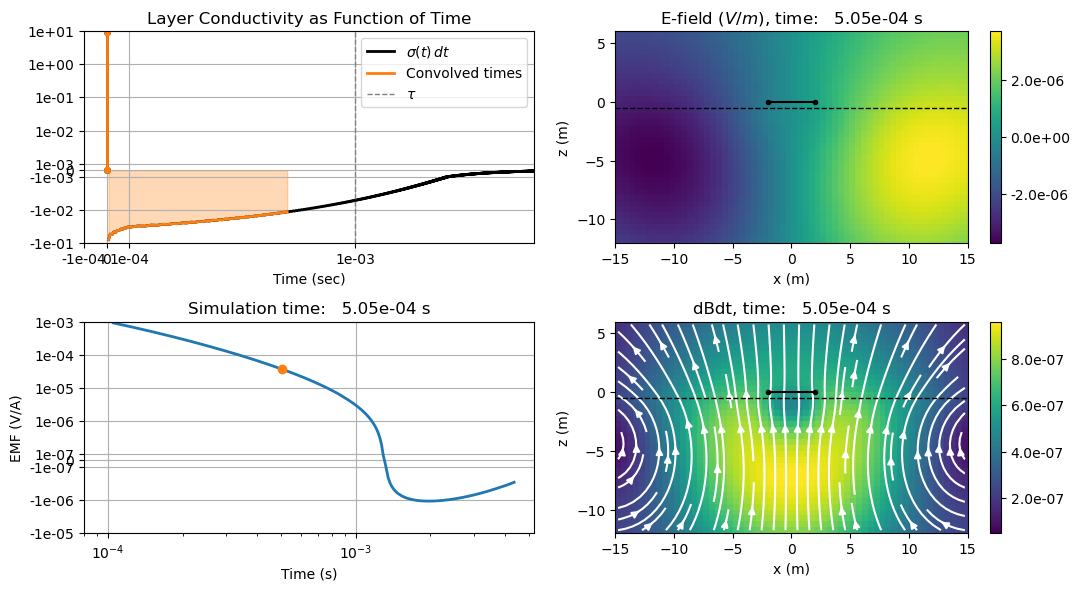

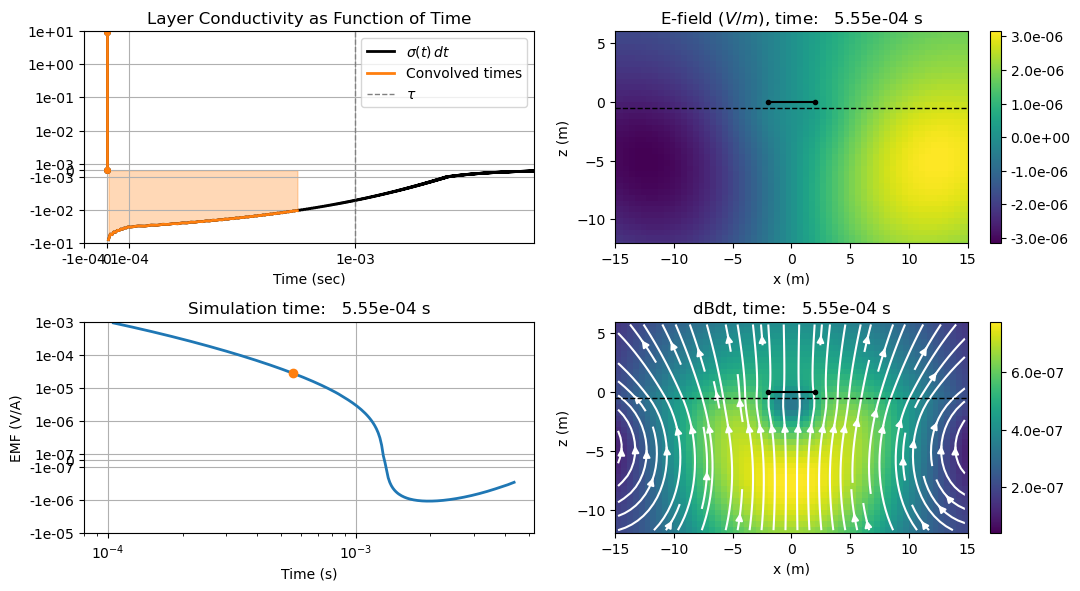

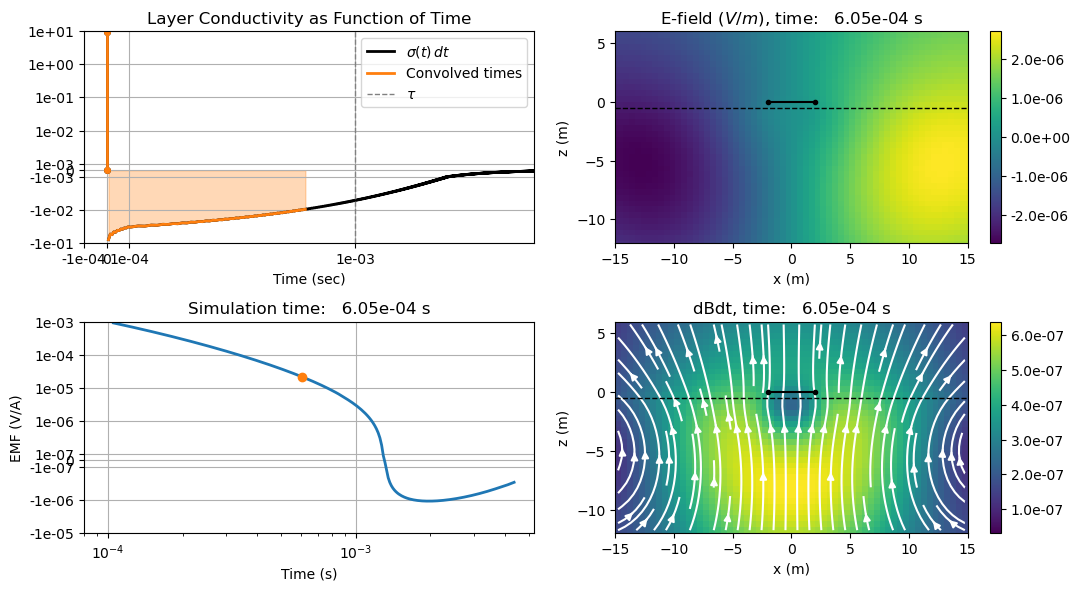

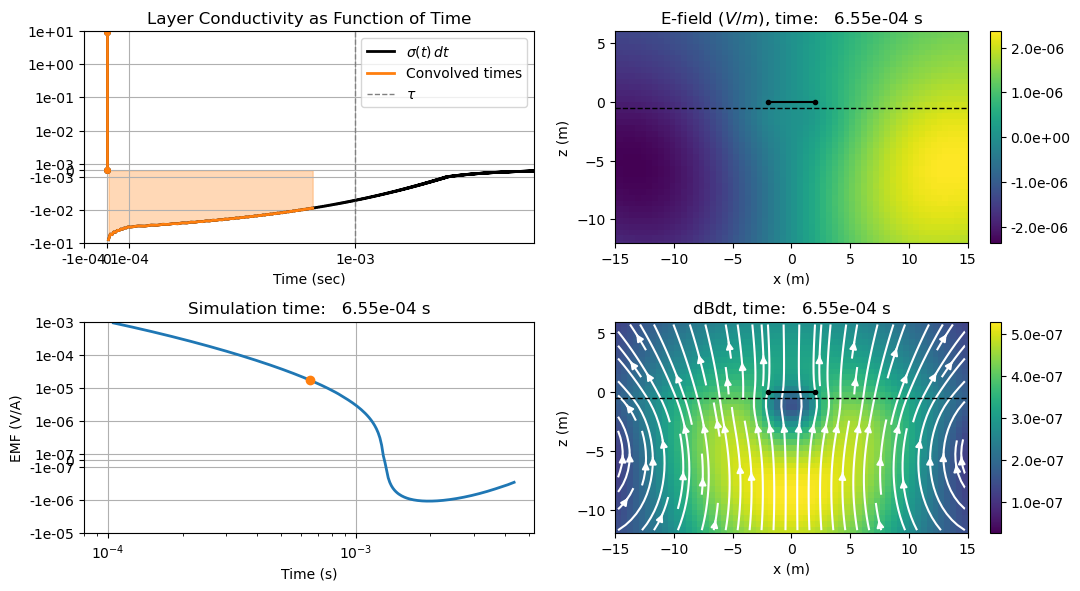

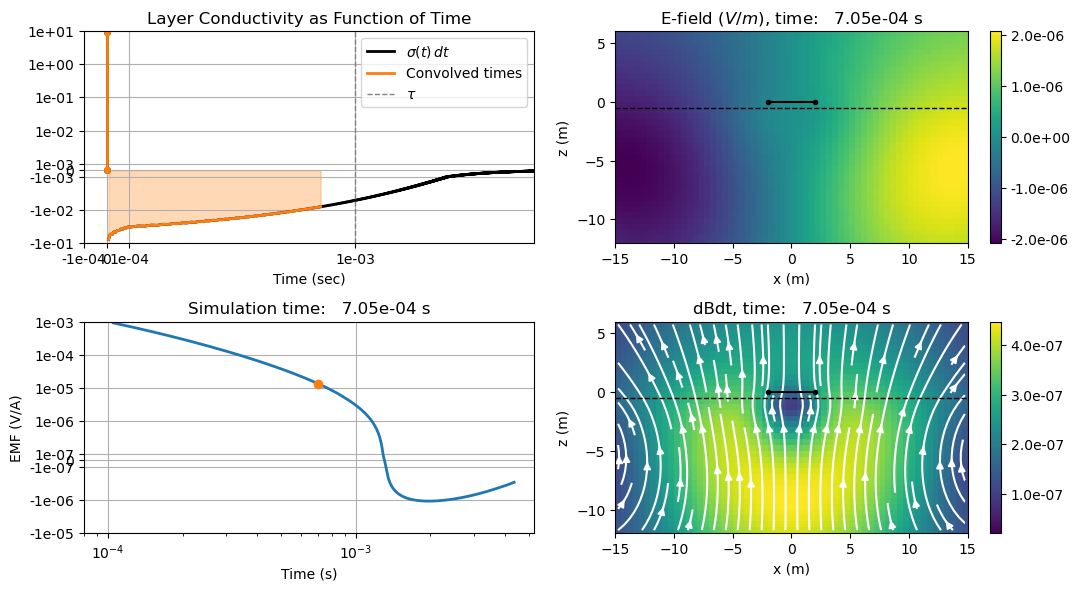

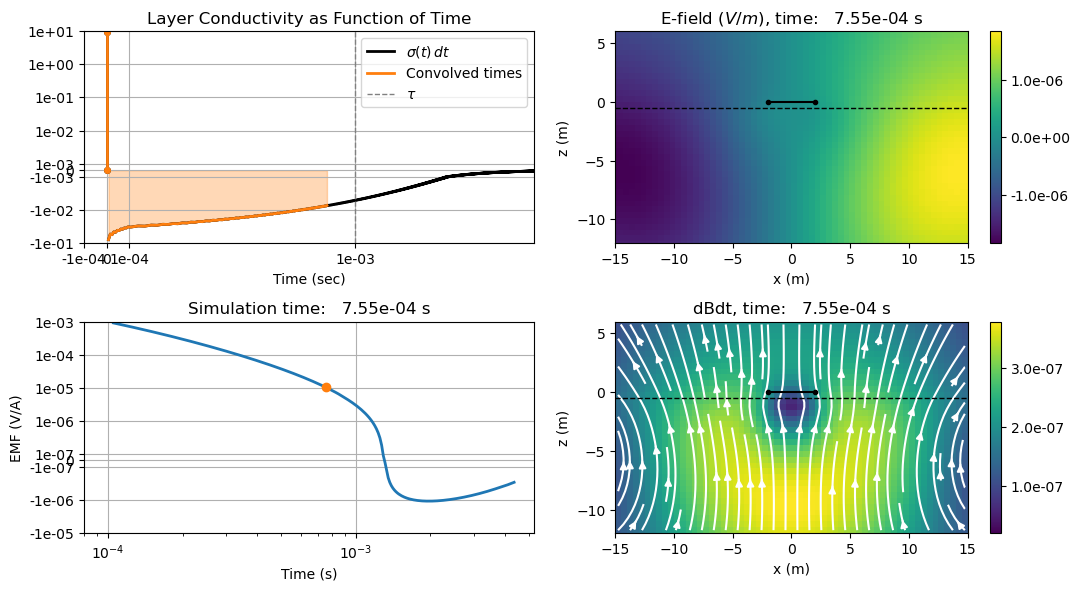

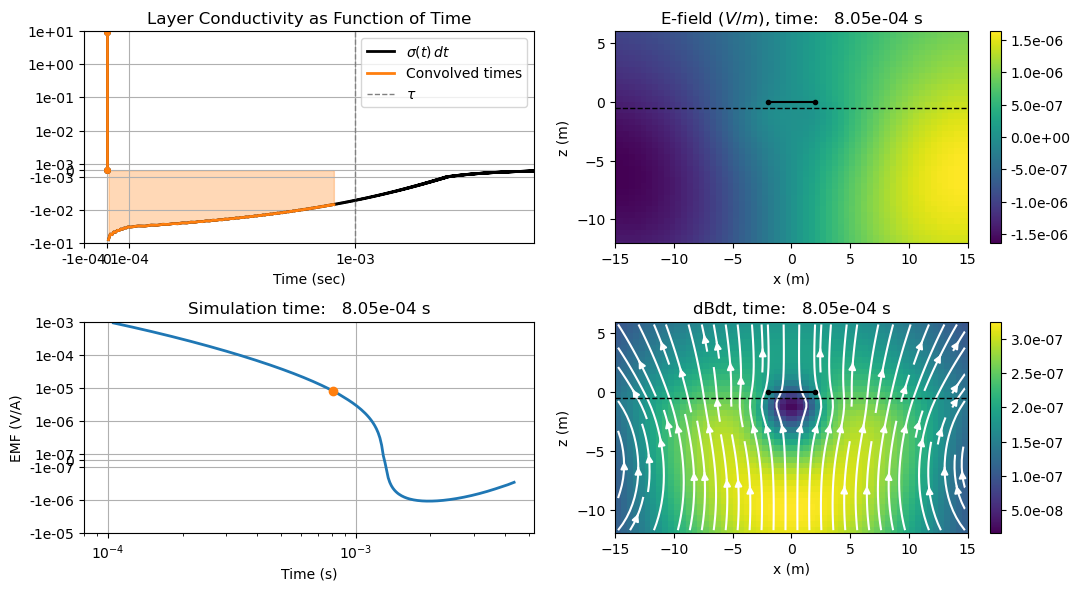

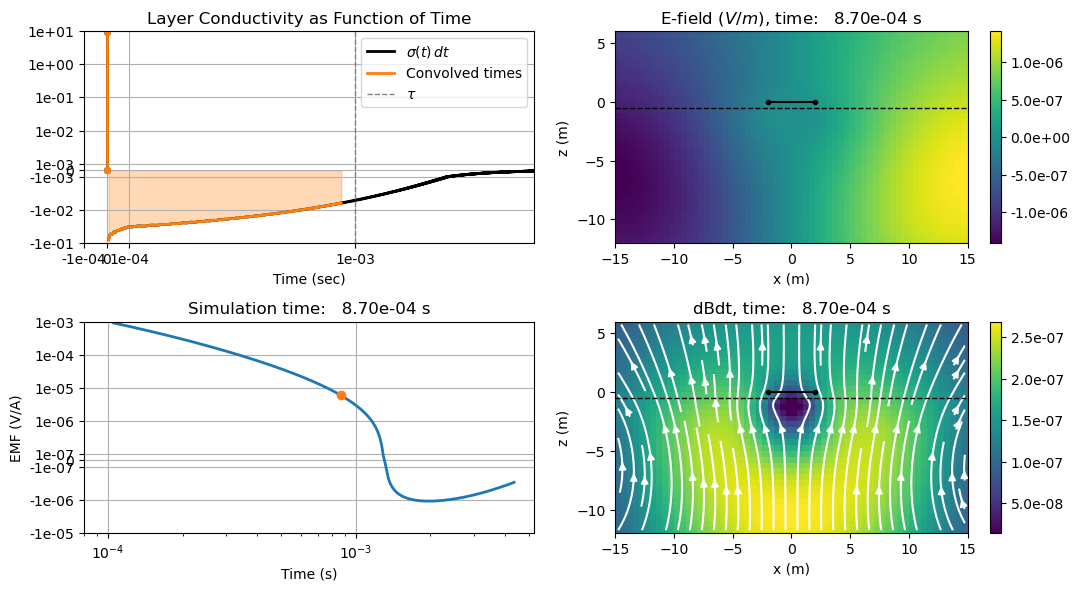

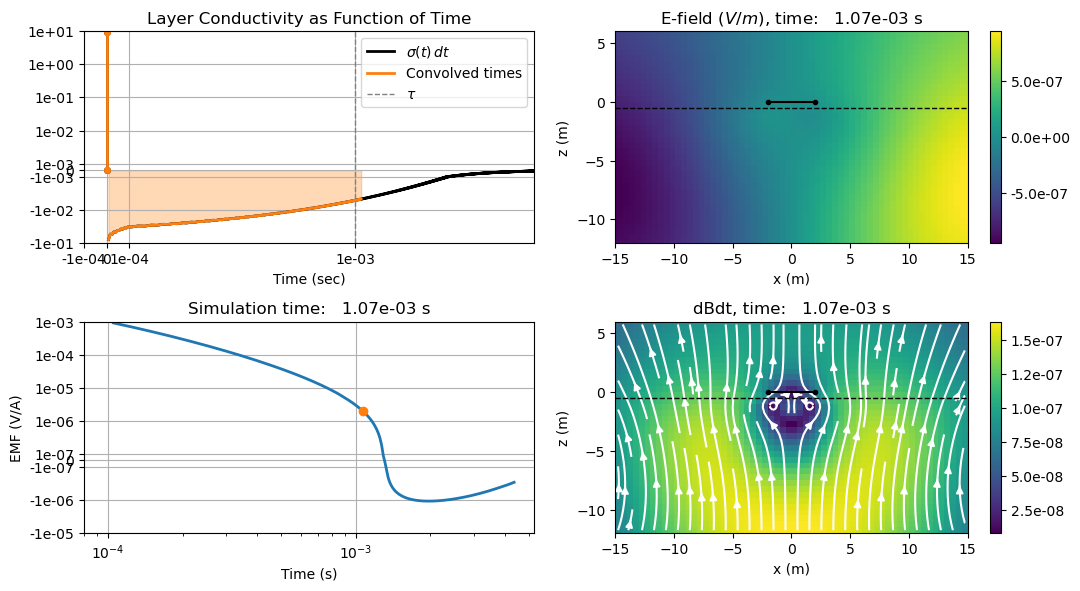

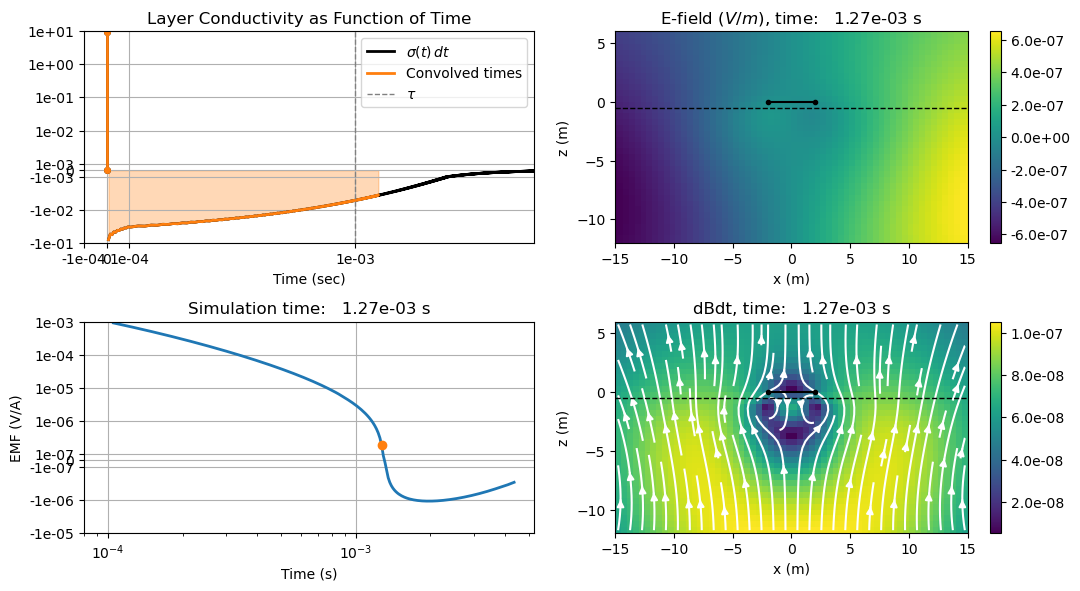

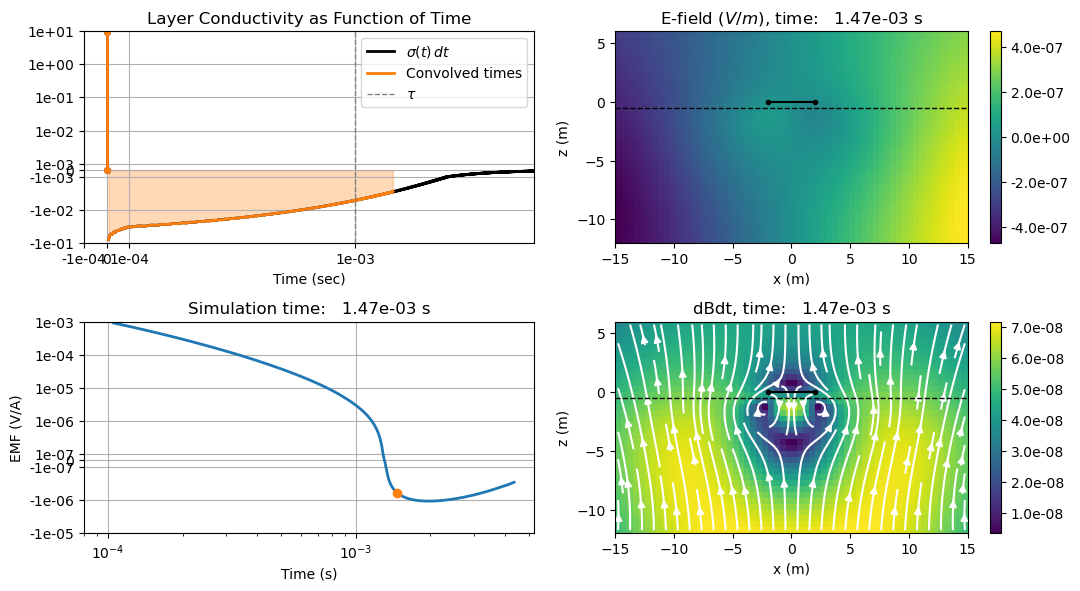

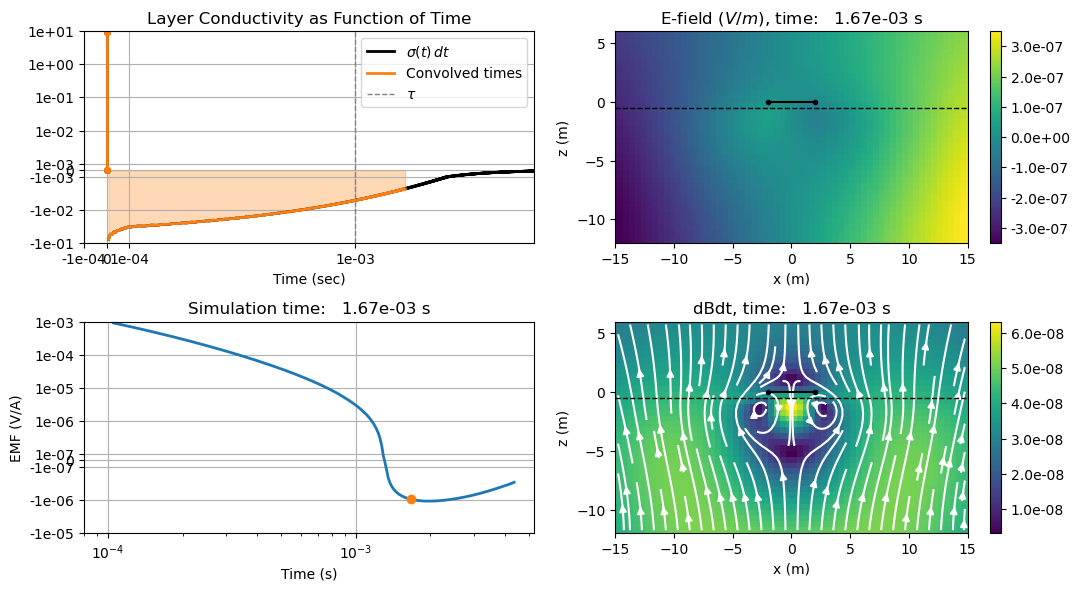

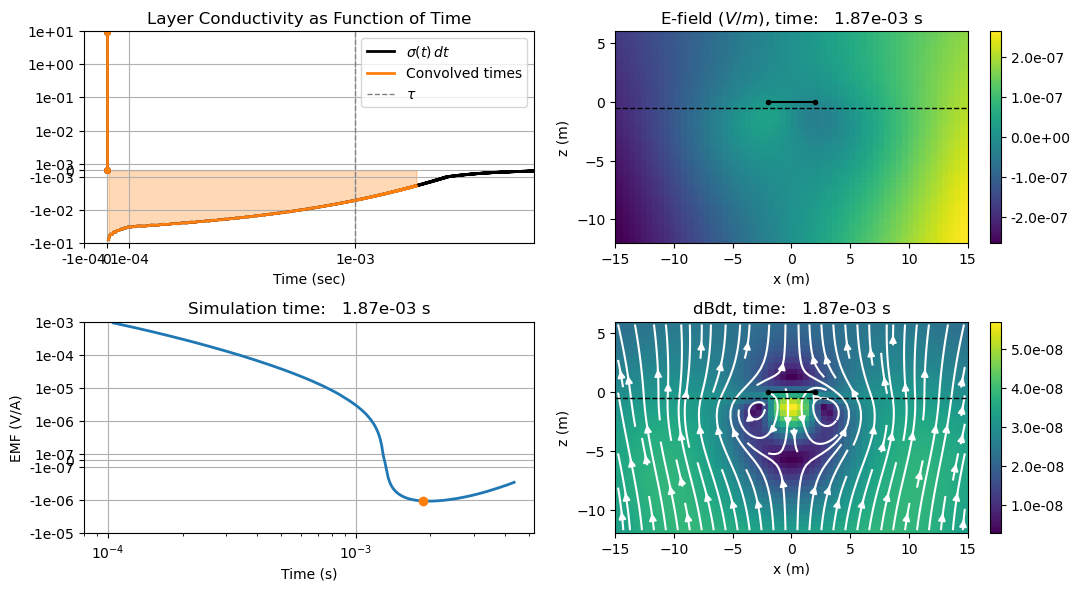

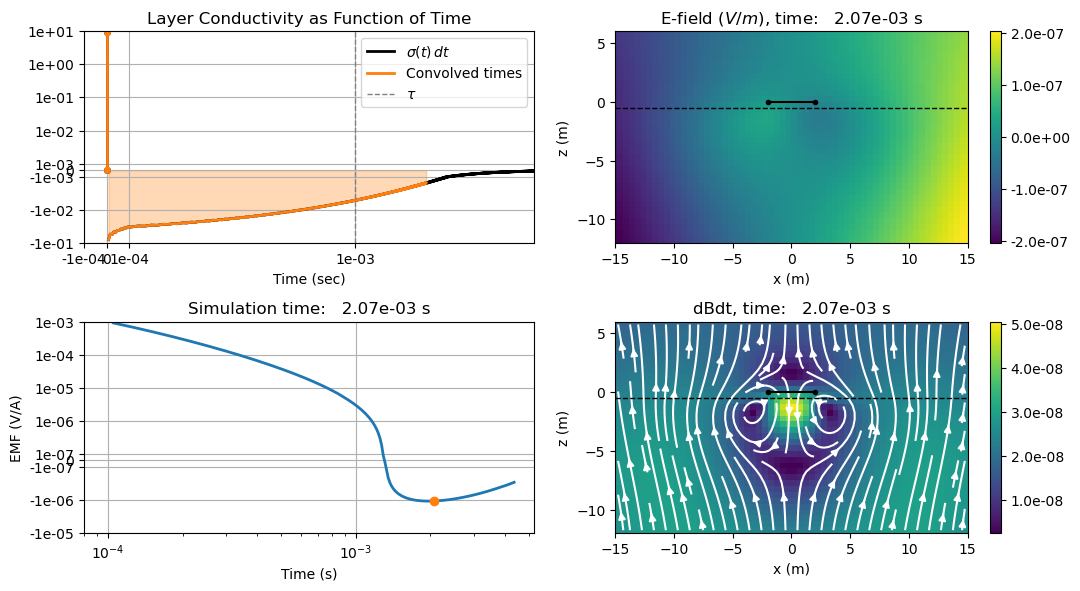

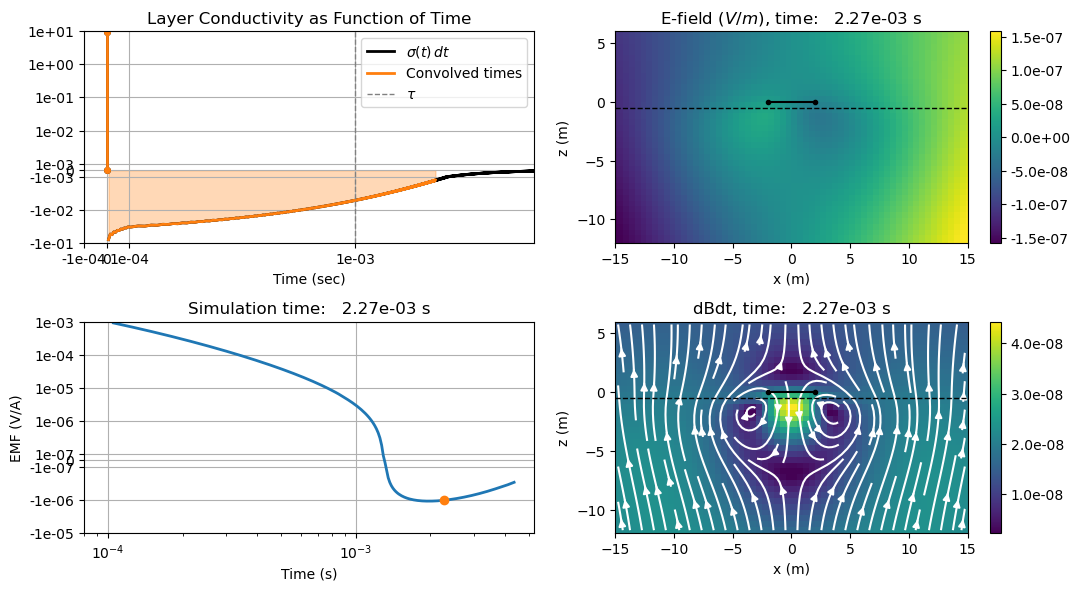

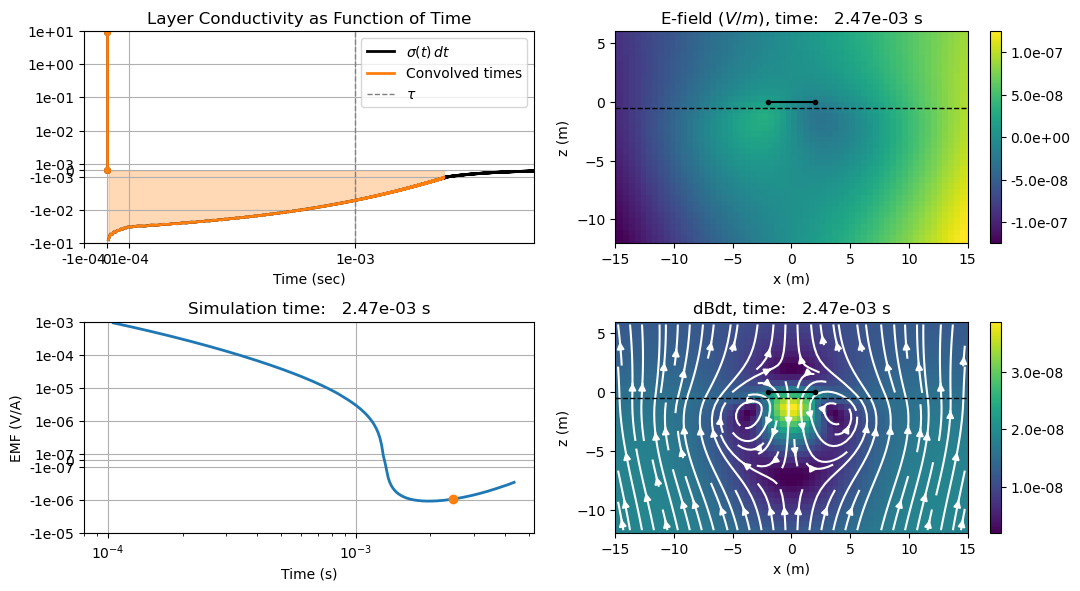

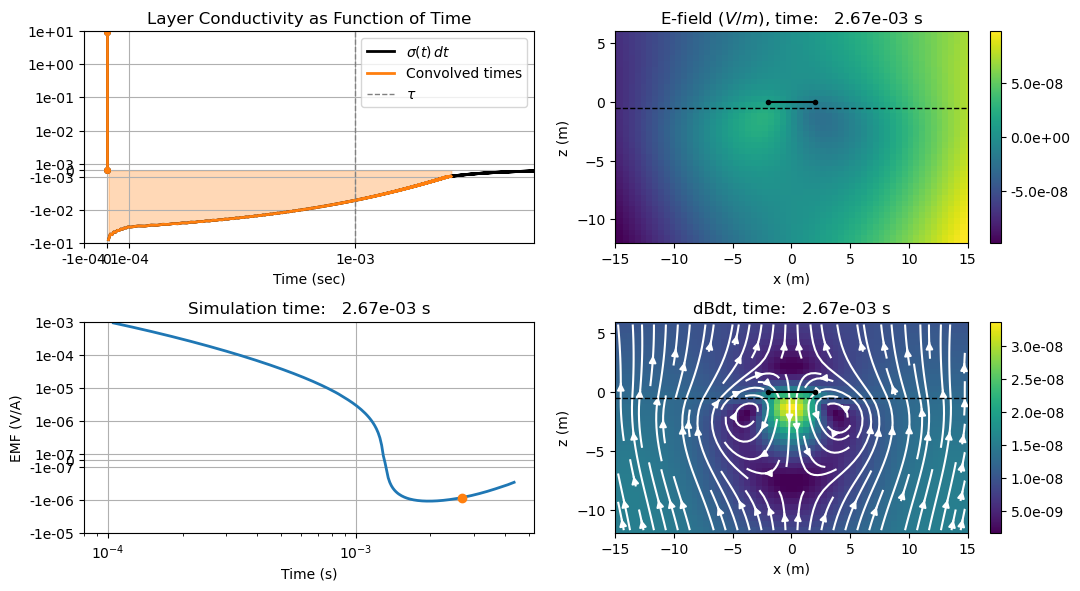

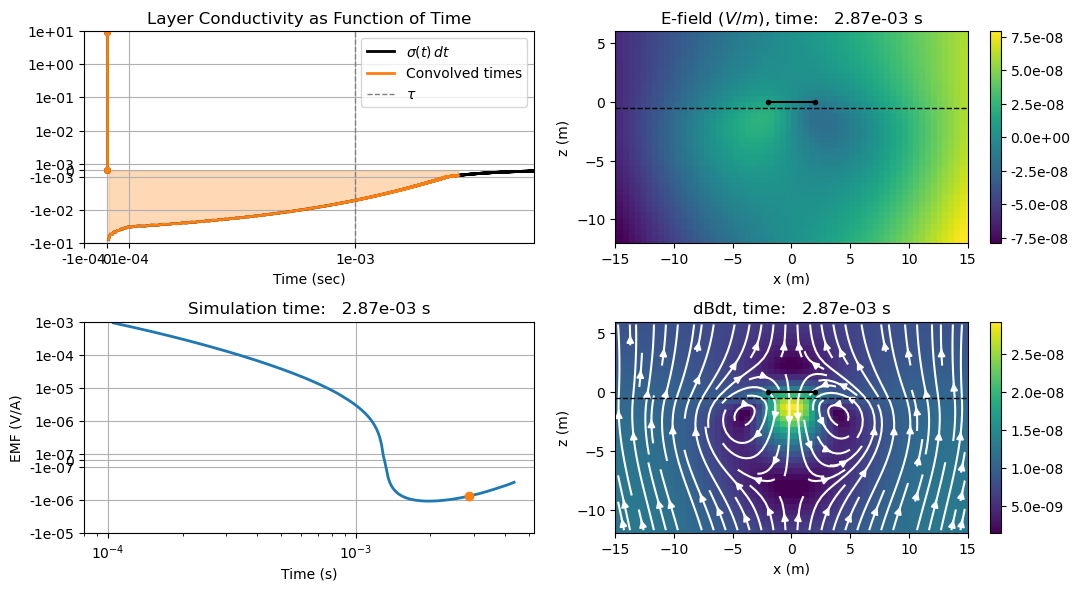

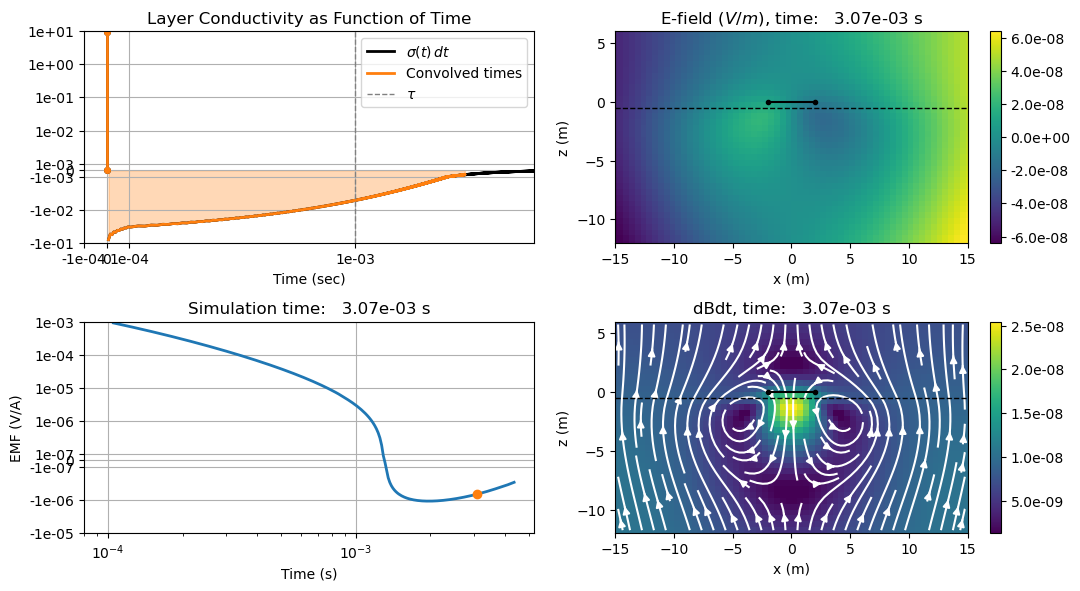

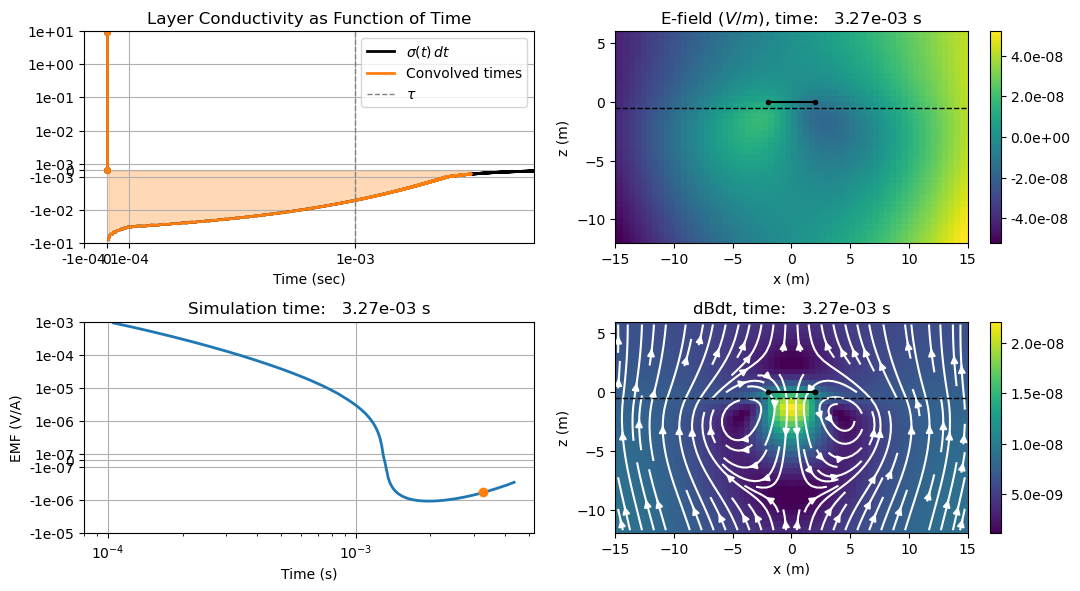

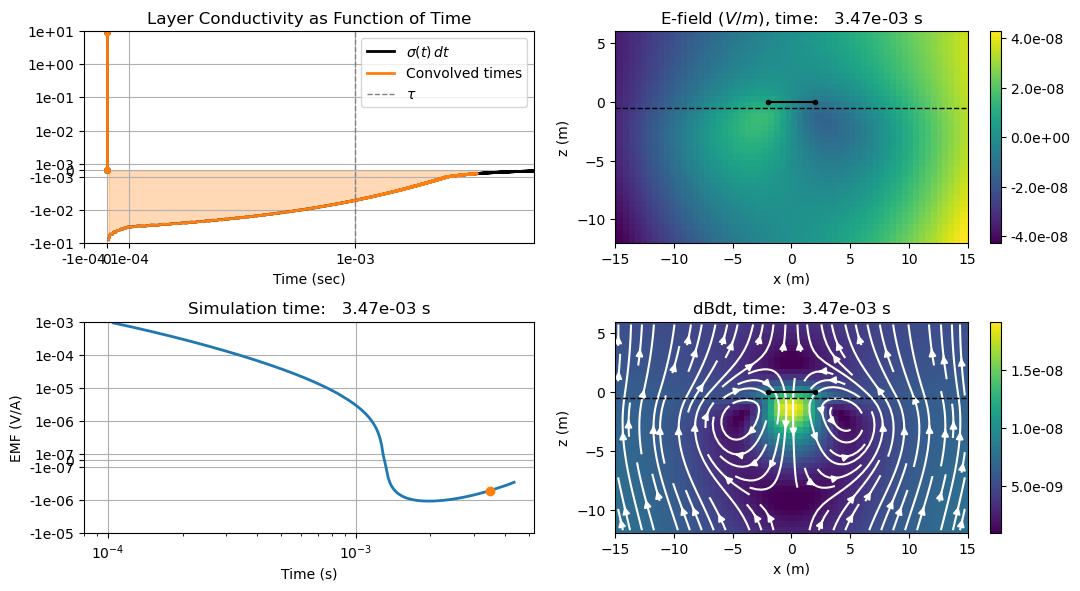

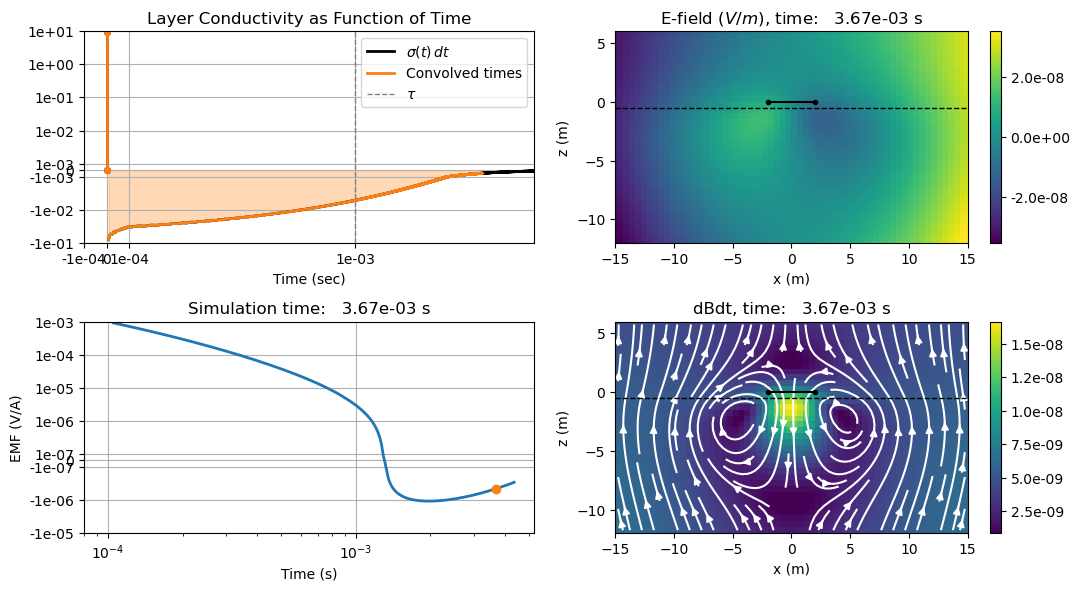

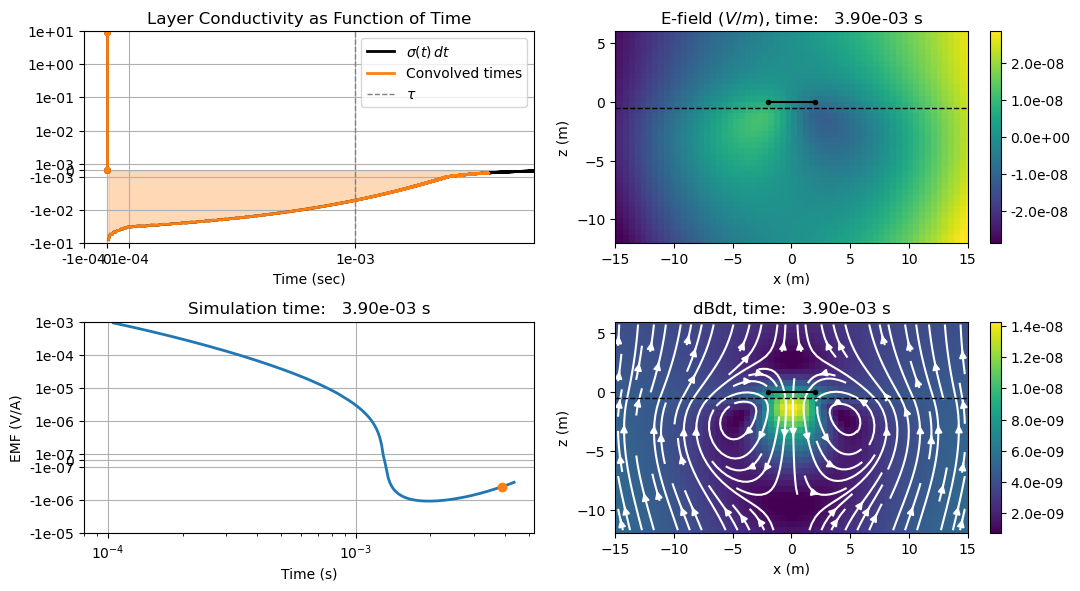

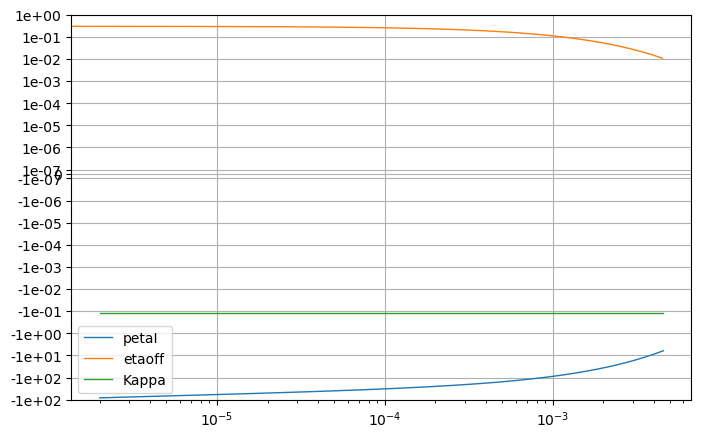

In [49]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
ax=PL_eta.semiply(x=eta_times1,y=-eta_petaI,
        linestyle="-",label="petaI", color="C0",ax=ax)
ax=PL_eta.semiply(x=eta_times0,y= eta_petaoff,
        linestyle="-",label="etaoff", color="C1",ax=ax)
ax=PL_eta.semiply(x=eta_times1,y= eta_kappa,
        linestyle="-",label="Kappa", color="C2",ax=ax)
PL_eta.pl_axes(ax=ax)

ax.grid()
ax.legend()

In [50]:
plt.loglog(eta_times1,eta_peta0, label="peta0")
plt.loglog(eta_times1,eta_peta1, label="peta1")
#plt.loglog(eta_times1,eta_peta*eta_time_steps)

plt.loglog(eta_times1,-eta_kappa, label="kappa")#/eta_time_steps)
##plt.loglog(eta_times1,-eta_kappa )#/eta_time_steps)

plt.loglog(eta_times1,-eta_gamma, label="gamma")
plt.grid()
plt.legend()

NameError: name 'eta_peta0' is not defined